In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate, correlation_lags, find_peaks_cwt
from scipy.integrate import trapz
from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import cmocean

# Identify peaks in salinity and SCHA/bc filtered signals to identify events and eventually create the intensity-duration plot

## cosine lanczos filter

In [3]:
#function comes from schimpy metricsplot.py script https://github.com/CADWRDeltaModeling/schimpy/blob/master/schimpy/metricsplot.py
def filter_timeseries(tss, cutoff_period=hours(40)):
    """ Filter time series

        Parameters
        ----------

        Returns
        -------
        list of vtools.data.timeseries.TimeSeries
            filtered time series
    """

    filtered = []
    ts=tss #try removing the loop for now
    if ts is None:
        filtered.append(None)
    else:
        #print(ts)
        ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
        ts_filtered.filtered = 'cosine_lanczos'
        #ts_filtered.unit = ts.unit
        #filtered.append(ts_filtered)
    # for ts in tss:
    #     if ts is None:
    #         filtered.append(None)
    #     else:
    #         print(ts)
    #         ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
    #         ts_filtered.filtered = 'cosine_lanczos'
    #         ts_filtered.unit = ts.unit
    #         filtered.append(ts_filtered)
    return ts_filtered

In [4]:
#load the SCHA filtered signal for Point Reyes 
#use Eli's SCHA filter subtide that I then subtracted the 40 day box car from
ptreyes=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/bcfiltered_SCHA_subtide_ptreyes.csv")
dtformat = '%Y-%m-%dT%H:%M:%S'
ptreyes['datetime'] = pd.to_datetime(ptreyes['datetime'],format=dtformat)
pr_filt=ptreyes[['datetime','box_40d_filt']].rename(columns={"box_40d_filt": "Residual"})
pr_filt.set_index("datetime",inplace=True)
pr_filt

,Residual
datetime,
2012-01-03 01:30:00,NaN
2012-01-03 02:00:00,NaN
2012-01-03 02:30:00,NaN
2012-01-03 03:00:00,NaN
2012-01-03 03:30:00,NaN
...,...
2023-12-29 20:30:00,NaN
2023-12-29 21:00:00,NaN
2023-12-29 21:30:00,NaN


In [5]:
pr_filt.Residual[2000:2100].values

array([ 1.96859375e-03, -2.80729167e-05, -1.82536458e-03, -3.52328125e-03,
       -5.22177083e-03, -6.82083333e-03, -8.22041667e-03, -9.62046875e-03,
       -1.09209375e-02, -1.21218229e-02, -1.31230729e-02, -1.41247396e-02,
       -1.50267187e-02, -1.58290104e-02, -1.65315625e-02, -1.71343750e-02,
       -1.76373958e-02, -1.80406250e-02, -1.83440625e-02, -1.86476563e-02,
       -1.88514063e-02, -1.89553125e-02, -1.90592708e-02, -1.90632813e-02,
       -1.89673437e-02, -1.89714062e-02, -1.87754688e-02, -1.86794792e-02,
       -1.84833854e-02, -1.81871875e-02, -1.79908333e-02, -1.77942708e-02,
       -1.74975000e-02, -1.72004687e-02, -1.70031250e-02, -1.67054688e-02,
       -1.64073958e-02, -1.62089583e-02, -1.59100000e-02, -1.57105729e-02,
       -1.55106250e-02, -1.53100521e-02, -1.52088542e-02, -1.51069792e-02,
       -1.51043750e-02, -1.51009896e-02, -1.50967708e-02, -1.51917187e-02,
       -1.52857292e-02, -1.53787500e-02, -1.55707292e-02, -1.58616667e-02,
       -1.61515104e-02, -

<AxesSubplot:xlabel='datetime'>

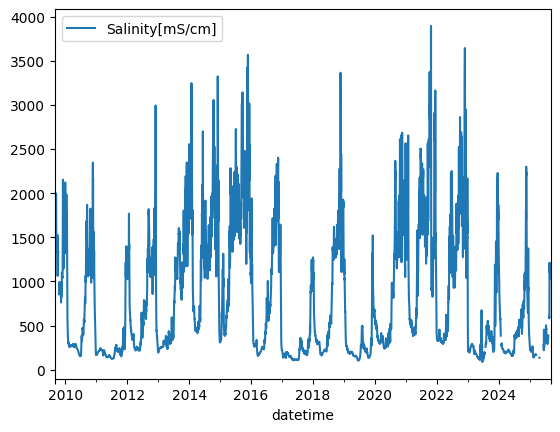

In [6]:
#load the jersey point data, use the sjj signal to gap fill the jer, and load the holland cut salinity data, filter with cosine lanczos filter
jer_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_jer.csv")
jer_dms=jer_dms.rename(columns={"screened/jer//usbr/JER/ec/microS/cm": "Salinity[mS/cm]"})
jer_dms['datetime']=pd.to_datetime(jer_dms['datetime'],format=dtformat)
jer_dms.set_index("datetime",inplace=True)


sjj_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_sjj.csv")
sjj_dms=sjj_dms.rename(columns={"screened/sjj//usgs/11337190/ec/microS/cm": "Salinity[mS/cm]"})
sjj_dms['datetime']=pd.to_datetime(sjj_dms['datetime'],format=dtformat)
sjj_dms.set_index("datetime",inplace=True)

#gapfill
jp=jer_dms.fillna(sjj_dms)
jp=jp.asfreq('15min')
jp_filt=filter_timeseries(jp)

hol2_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_hol2.csv")
hol2_dms=hol2_dms.rename(columns={"screened/hol2//dwr_ncro/B95120/ec/microS/cm": "Salinity[mS/cm]"})
hol2_dms['datetime']=pd.to_datetime(hol2_dms['datetime'],format=dtformat)
hol2_dms.set_index("datetime",inplace=True)
hol2_dms=hol2_dms.asfreq('15min')
hol2_dms_filt=filter_timeseries(hol2_dms)

frk=pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/frkdefault_ec_screened_2021.csv',skiprows=65)#.set_index('datetime')
frk=frk.rename(columns={"value": "Salinity[mS/cm]"})
frk['datetime']=pd.to_datetime(frk['datetime'],format=dtformat)
frk.set_index("datetime",inplace=True)
frk=frk.asfreq('15min')
frk_filt=filter_timeseries(frk.drop(columns=['user_flag']))

jp_filt.plot()

In [7]:
frk_filt

,Salinity[mS/cm]
datetime,
2015-07-01 00:00:00,NaN
2015-07-01 00:15:00,NaN
2015-07-01 00:30:00,NaN
2015-07-01 00:45:00,NaN
2015-07-01 01:00:00,NaN
...,...
2025-07-14 17:00:00,NaN
2025-07-14 17:15:00,NaN
2025-07-14 17:30:00,NaN


In [8]:
# # save these 2 filtered datasets so we don't have to keep doing this
# jp_filt.to_csv("/global/scratch/users/jennaisrael/time_varying_data/salinity/jersey_point_jer_sjj_filled_cl_filtered.csv")
# hol2_dms_filt.to_csv("/global/scratch/users/jennaisrael/time_varying_data/salinity/holland_cut_hol2_cl_filtered.csv")

# DO NOT DOWNSAMPLE THE SALINITY DATA

In [9]:
# #downsample the salinity data to also be every half hour
# jp_filt=jp_filt.resample('30min').mean()
# hol2_dms_filt=hol2_dms_filt.resample('30min').mean()

In [10]:
#what are the time frames of these data?
print("Point Reyes SCHA & BC filt time range: "+str(pr_filt.first_valid_index())+" - "+str(pr_filt.last_valid_index()))
print("Jersey Point time range: "+str(jp_filt.first_valid_index())+" - "+str(jp_filt.last_valid_index()))
print("Franks Tract time range: "+str(frk_filt.first_valid_index())+" - "+str(frk_filt.last_valid_index()))
print("Holland Cut time range: "+str(hol2_dms_filt.first_valid_index())+" - "+str(hol2_dms_filt.last_valid_index()))


Point Reyes SCHA & BC filt time range: 2012-02-12 01:30:00 - 2023-11-19 22:30:00
Jersey Point time range: 2009-09-04 15:00:00 - 2025-08-29 01:30:00
Franks Tract time range: 2015-07-05 04:00:00 - 2025-07-10 14:00:00
Holland Cut time range: 2009-09-07 16:00:00 - 2025-09-03 19:00:00


# Confine our search to water years 2013 to 2024

In [11]:
# # Try out python's peak finding method in the signal toolbox
# pr_trim=pr_filt.Residual[2000:3000].values
# peaks, _ = find_peaks(pr_trim, height=0)

# plt.plot(pr_trim)

# plt.plot(peaks, pr_trim[peaks], "x")

# plt.plot(np.zeros_like(pr_trim), "--", color="gray")

# plt.show()


In [12]:
# #repeat for salinity (harder)
# jp_trim=jp_filt['Salinity[mS/cm]'][2000:3000].values
# peaks, _ = find_peaks(jp_trim, height=0)

# plt.plot(jp_trim)

# plt.plot(peaks, jp_trim[peaks], "x")

# plt.plot(np.zeros_like(jp_trim), "--", color="gray")

# plt.show()

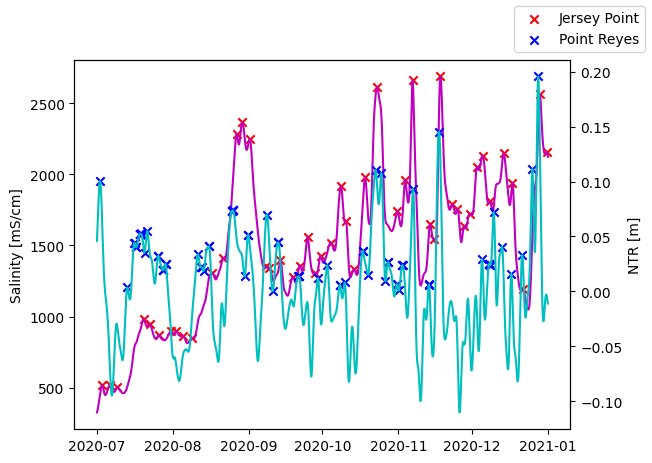

47 peaks identified for Jersey Point
85 peaks identified for Point Reyes


In [13]:
#try instead looking at a range we have examined previously 
jp_f2020=jp_filt['Salinity[mS/cm]'].loc[datetime(2020,7,1):datetime(2021,1,1)].values
pr_f2020=pr_filt['Residual'].loc[datetime(2020,7,1):datetime(2021,1,1)].values
peaksjp, _ = find_peaks(jp_f2020, height=0)
peakspr, _ = find_peaks(pr_f2020, height=0)

fig, ax= plt.subplots(sharex=True)
ax.plot(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index,jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='m')
ax.scatter(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peaksjp].index, jp_f2020[peaksjp], label="Jersey Point",marker="x",color='r')
#ax.plot(np.zeros_like(jp_f2020), "--", color="gray")
ax.set_ylabel('Salinity [mS/cm]')

ax2=ax.twinx() 
ax2.plot(pr_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index,pr_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='c')
ax2.scatter(pr_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peakspr].index, pr_f2020[peakspr], label="Point Reyes",marker="x",color='b')
#ax2.plot(np.zeros_like(pr_f2020), "--", color="gray")
ax2.set_ylabel('NTR [m]')

fig.legend()

plt.show()
print(str(len(peaksjp))+' peaks identified for Jersey Point')
print(str(len(peakspr))+' peaks identified for Point Reyes')

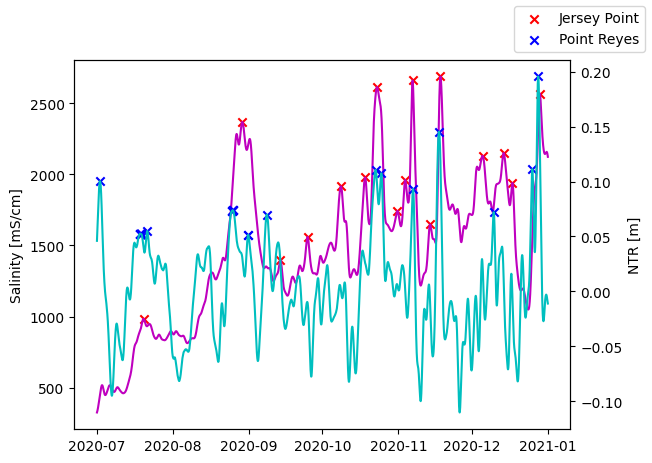

16 peaks identified for Jersey Point
30 peaks identified for Point Reyes


In [14]:
#repeat but with a threshold for prominence 
peaksjp, _ = find_peaks(jp_f2020, prominence=100)
peakspr, _ = find_peaks(pr_f2020, height=0.05)

fig, ax= plt.subplots(sharex=True)
ax.plot(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index,jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='m')
ax.scatter(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peaksjp].index, jp_f2020[peaksjp], label="Jersey Point",marker="x",color='r')
#ax.plot(np.zeros_like(jp_f2020), "--", color="gray")
ax.set_ylabel('Salinity [mS/cm]')

ax2=ax.twinx() 
ax2.plot(pr_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index,pr_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='c')
ax2.scatter(pr_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peakspr].index, pr_f2020[peakspr], label="Point Reyes",marker="x",color='b')
#ax2.plot(np.zeros_like(pr_f2020), "--", color="gray")
ax2.set_ylabel('NTR [m]')

fig.legend()

plt.show()
print(str(len(peaksjp))+' peaks identified for Jersey Point')
print(str(len(peakspr))+' peaks identified for Point Reyes')

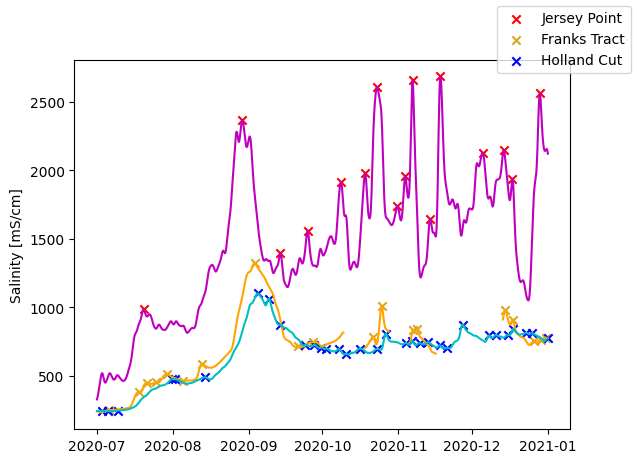

16 peaks identified for Jersey Point
19 peaks identified for Franks Tract
32 peaks identified for Holland Cut


In [15]:
#Salinity 
frk_f2020=frk_filt['Salinity[mS/cm]'].loc[datetime(2020,7,1):datetime(2021,1,1)].values
peaksfrk, _ = find_peaks(frk_f2020, height=0)
hol2_f2020=hol2_dms_filt['Salinity[mS/cm]'].loc[datetime(2020,7,1):datetime(2021,1,1)].values
peakshol2, _ = find_peaks(hol2_f2020, height=0)

fig, ax= plt.subplots(sharex=True)
ax.plot(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index,jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='m')
ax.scatter(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peaksjp].index, jp_f2020[peaksjp], label="Jersey Point",marker="x",color='r')
ax.set_ylabel('Salinity [mS/cm]')
#plot salinity on the same axis this time

#ax.plot(frk_f2020,color='orange')
ax.plot(frk_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index, frk_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='orange')
ax.scatter(frk_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peaksfrk].index, frk_f2020[peaksfrk], label="Franks Tract",marker="x",color='goldenrod')
#ax.plot(np.zeros_like(frk_f2020), "--", color="gray")


ax.plot(hol2_dms_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index, hol2_dms_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='c')
ax.scatter(hol2_dms_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peakshol2].index, hol2_f2020[peakshol2], label="Holland Cut",marker="x",color='b')


fig.legend()

plt.show()
print(str(len(peaksjp))+' peaks identified for Jersey Point')
print(str(len(peaksfrk))+' peaks identified for Franks Tract')
print(str(len(peakshol2))+' peaks identified for Holland Cut')


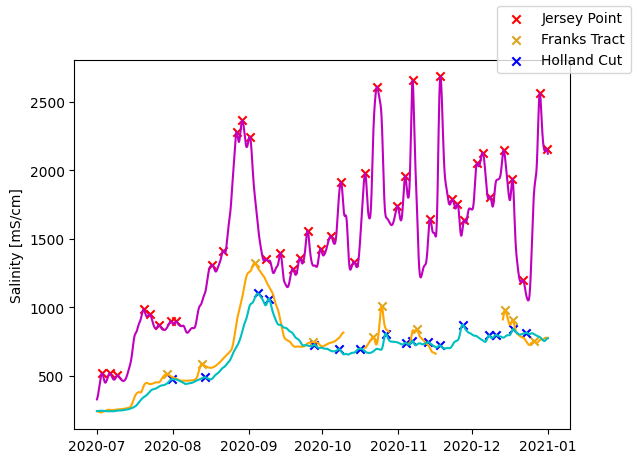

40 peaks identified for Jersey Point
10 peaks identified for Franks Tract
17 peaks identified for Holland Cut


In [16]:
# probably need a minimum peak height for salinity
peaksjp10, _ = find_peaks(jp_f2020, prominence=10) #height is relative to 0! Not relative to the local "baseline", prominence is relative to baseline
peakshol210, _ = find_peaks(hol2_f2020, prominence=10)
peaksfrk10, _ = find_peaks(frk_f2020, prominence=10)

fig, ax= plt.subplots(sharex=True)
ax.plot(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index,jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='m')
ax.scatter(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peaksjp10].index, jp_f2020[peaksjp10], label="Jersey Point",marker="x",color='r')
ax.set_ylabel('Salinity [mS/cm]')
#plot salinity on the same axis this time

#ax.plot(frk_f2020,color='orange')
ax.plot(frk_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index, frk_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='orange')
ax.scatter(frk_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peaksfrk10].index, frk_f2020[peaksfrk10], label="Franks Tract",marker="x",color='goldenrod')
#ax.plot(np.zeros_like(frk_f2020), "--", color="gray")


ax.plot(hol2_dms_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index, hol2_dms_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='c')
ax.scatter(hol2_dms_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peakshol210].index, hol2_f2020[peakshol210], label="Holland Cut",marker="x",color='b')


fig.legend()

plt.show()
print(str(len(peaksjp10))+' peaks identified for Jersey Point')
print(str(len(peaksfrk10))+' peaks identified for Franks Tract')
print(str(len(peakshol210))+' peaks identified for Holland Cut')

# Can we use the max cross-correlation (lag) to inform this analysis?

In [17]:
jp_filt['Salinity[mS/cm]'].loc[datetime(2012,2,12):datetime(2023,11,19)]

datetime
2012-02-12 00:00:00     473.286732
2012-02-12 00:15:00     473.139371
2012-02-12 00:30:00     472.994528
2012-02-12 00:45:00     472.852261
2012-02-12 01:00:00     472.712627
                          ...     
2023-11-18 23:00:00    1114.789736
2023-11-18 23:15:00    1110.225618
2023-11-18 23:30:00    1105.538295
2023-11-18 23:45:00    1100.729652
2023-11-19 00:00:00    1095.801685
Freq: 15T, Name: Salinity[mS/cm], Length: 412609, dtype: float64

In [18]:
print(len(jp_filt['Salinity[mS/cm]'].loc[datetime(2012,2,13):datetime(2023,11,19)].resample('30min').mean().dropna()))
jp_filt['Salinity[mS/cm]'].loc[datetime(2012,2,13):datetime(2023,11,19)].resample('30min').mean()

203733


datetime
2012-02-13 00:00:00     471.977879
2012-02-13 00:30:00     472.048196
2012-02-13 01:00:00     472.106529
2012-02-13 01:30:00     472.151668
2012-02-13 02:00:00     472.182421
                          ...     
2023-11-18 22:00:00    1129.752935
2023-11-18 22:30:00    1121.385108
2023-11-18 23:00:00    1112.507677
2023-11-18 23:30:00    1103.133973
2023-11-19 00:00:00    1095.801685
Freq: 30T, Name: Salinity[mS/cm], Length: 206257, dtype: float64

In [19]:
jp_filt['Salinity[mS/cm]'].loc[datetime(2012,2,13):datetime(2023,11,19)].resample('30min').mean().dropna().to_frame() 

,Salinity[mS/cm]
datetime,
2012-02-13 00:00:00,471.977879
2012-02-13 00:30:00,472.048196
2012-02-13 01:00:00,472.106529
2012-02-13 01:30:00,472.151668
2012-02-13 02:00:00,472.182421
...,...
2023-11-18 22:00:00,1129.752935
2023-11-18 22:30:00,1121.385108
2023-11-18 23:00:00,1112.507677


In [20]:
print(len(pr_filt['Residual'].loc[datetime(2012,2,13):datetime(2023,11,19)].dropna()))
pr_filt['Residual'].loc[datetime(2012,2,13):datetime(2023,11,19)]

206257


datetime
2012-02-13 00:00:00    0.084324
2012-02-13 00:30:00    0.082788
2012-02-13 01:00:00    0.081049
2012-02-13 01:30:00    0.079207
2012-02-13 02:00:00    0.077361
                         ...   
2023-11-18 22:00:00    0.024988
2023-11-18 22:30:00    0.018492
2023-11-18 23:00:00    0.012098
2023-11-18 23:30:00    0.005703
2023-11-19 00:00:00   -0.000590
Name: Residual, Length: 206257, dtype: float64

In [21]:
#jersey point signal has gaps, where are the gaps?
jp_trim_downsample=jp_filt['Salinity[mS/cm]'].loc[datetime(2012,2,13):datetime(2023,11,19)].resample('30min').mean().dropna().to_frame() 
#add a column to be the datetime
jp_trim_downsample['date_col']=np.array([d.to_datetime64() for d in jp_trim_downsample.index])
jp_trim_downsample
gapmin=pd.Timedelta('31min')
mask=jp_trim_downsample.date_col.diff().gt(gapmin)
# get values
starts = jp_trim_downsample.loc[mask.shift(-1, fill_value=False), 'date_col'].add(gapmin).astype(str)
stops = jp_trim_downsample.loc[mask, 'date_col'].sub(gapmin).astype(str)
# build output
out = list(zip(starts, stops))
out

[('2013-10-17 11:01:00', '2013-10-25 18:29:00'),
 ('2017-07-01 10:31:00', '2017-07-11 12:59:00'),
 ('2018-07-01 17:01:00', '2018-07-10 00:29:00'),
 ('2019-09-14 23:31:00', '2019-09-24 00:59:00'),
 ('2023-05-01 08:31:00', '2023-05-09 16:59:00'),
 ('2023-07-21 06:31:00', '2023-07-29 13:59:00')]

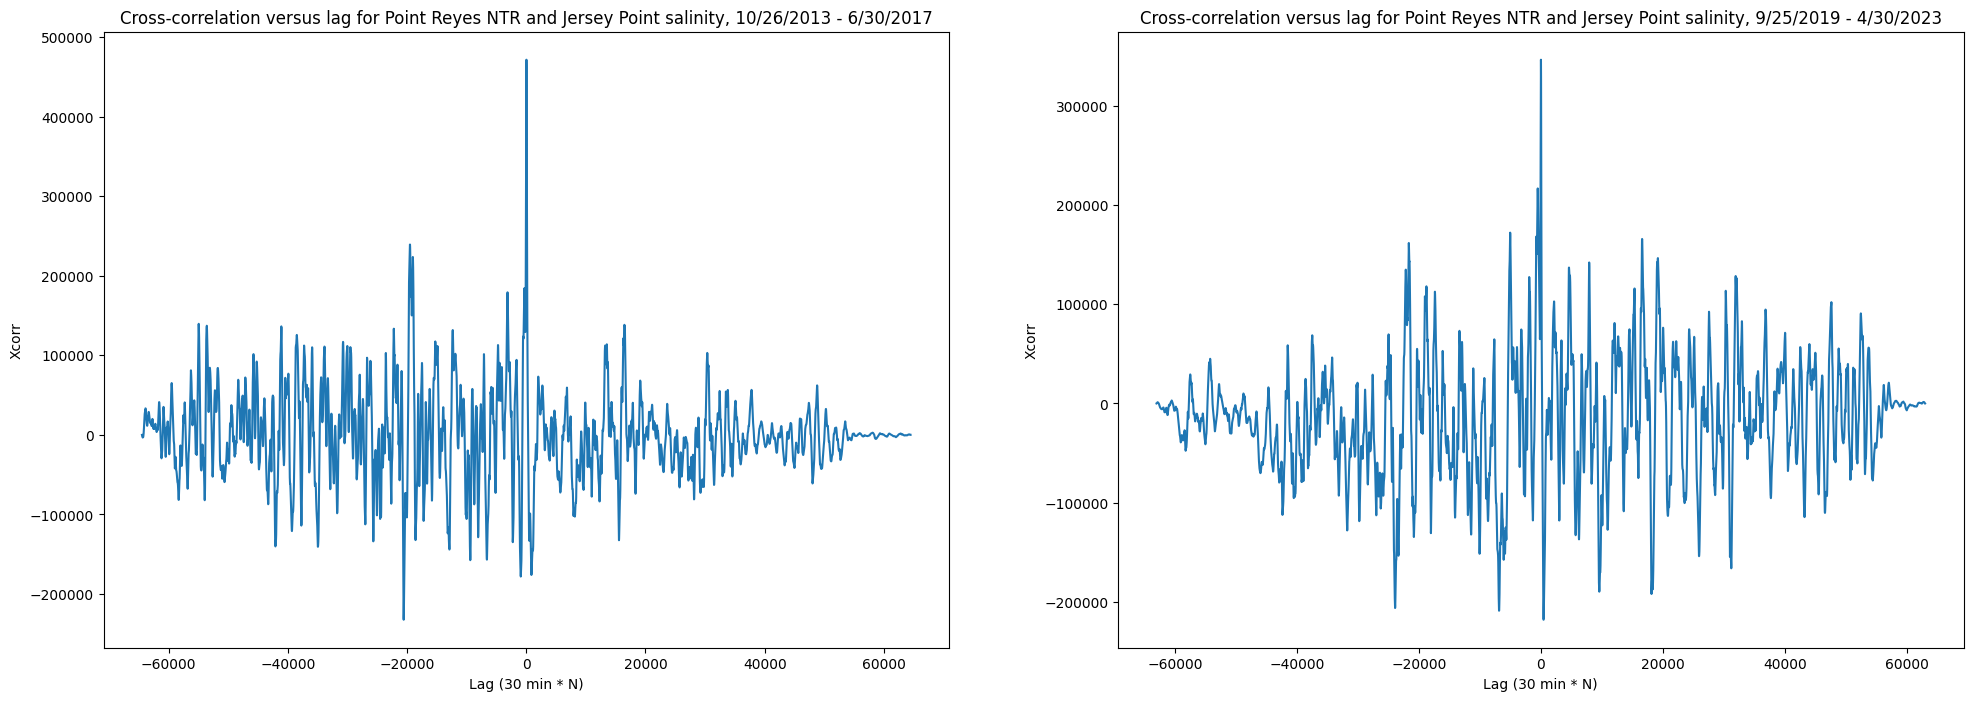

Lag of max cross-correlation for period 1 is 13.5 hours
Lag of max cross-correlation for period 2 is 11.5 hours


In [22]:
#find max lag for 2 periods of time where there are no gaps in salinity signal (a bit under 4 years for each)
jp_1=jp_filt['Salinity[mS/cm]'].loc[datetime(2013,10,26):datetime(2017,6,30)].resample('30min').mean().values
pr_1=pr_filt['Residual'].loc[datetime(2013,10,26):datetime(2017,6,30)].values
jp_2=jp_filt['Salinity[mS/cm]'].loc[datetime(2019,9,25):datetime(2023,4,30)].resample('30min').mean().values
pr_2=pr_filt['Residual'].loc[datetime(2019,9,25):datetime(2023,4,30)].values

corr1 = correlate(jp_1,pr_1)
lags1 = correlation_lags(len(jp_1),len(pr_1))
corr2 = correlate(jp_2,pr_2)
lags2 = correlation_lags(len(jp_2),len(pr_2))
# corr = correlate(jp_f2020, pr_f2020)
# lags = correlation_lags(len(jp_f2020), len(pr_f2020))
fig, ax= plt.subplots(1,2,figsize=(24,8))
ax[0].plot(lags1,corr1)
ax[0].set_xlabel('Lag (30 min * N)')
ax[0].set_ylabel('Xcorr')
ax[0].set_title('Cross-correlation versus lag for Point Reyes NTR and Jersey Point salinity, 10/26/2013 - 6/30/2017')

ax[1].plot(lags2,corr2)
ax[1].set_xlabel('Lag (30 min * N)')
ax[1].set_ylabel('Xcorr')
ax[1].set_title('Cross-correlation versus lag for Point Reyes NTR and Jersey Point salinity, 9/25/2019 - 4/30/2023')
plt.show()
print('Lag of max cross-correlation for period 1 is '+ str(lags1[corr1.argmax()]*0.5)+ ' hours')
print('Lag of max cross-correlation for period 2 is '+ str(lags2[corr2.argmax()]*0.5)+ ' hours')

In [23]:
#find the gaps for holland cut 
hol2_trim=hol2_dms_filt['Salinity[mS/cm]'].loc[datetime(2009,9,4):datetime(2025,8,28)].dropna().to_frame() 
#add a column to be the datetime
hol2_trim['date_col']=np.array([d.to_datetime64() for d in hol2_trim.index])
hol2_trim
gapminsal=pd.Timedelta('16min')
masksal=hol2_trim.date_col.diff().gt(gapminsal)
# get values
startssal = hol2_trim.loc[masksal.shift(-1, fill_value=False), 'date_col'].add(gapminsal).astype(str)
stopssal = hol2_trim.loc[masksal, 'date_col'].sub(gapminsal).astype(str)
# build output
outsal = list(zip(startssal, stopssal))
outsal

[('2009-09-17 07:16:00', '2009-09-25 15:14:00'),
 ('2010-01-10 07:01:00', '2010-01-18 14:59:00'),
 ('2010-07-04 07:31:00', '2010-07-12 15:44:00'),
 ('2011-01-06 08:16:00', '2011-01-14 16:14:00'),
 ('2011-01-28 08:16:00', '2011-02-05 16:14:00'),
 ('2011-02-07 07:31:00', '2011-02-15 15:29:00'),
 ('2011-02-19 07:31:00', '2011-02-27 15:29:00'),
 ('2011-03-11 06:46:00', '2011-03-19 14:44:00'),
 ('2011-04-02 06:31:00', '2011-04-10 14:29:00'),
 ('2011-04-22 06:31:00', '2011-04-30 14:29:00'),
 ('2011-05-13 06:46:00', '2011-05-21 14:44:00'),
 ('2011-06-03 07:46:00', '2011-06-18 17:14:00'),
 ('2011-06-24 07:16:00', '2011-07-02 15:14:00'),
 ('2011-07-17 06:16:00', '2011-07-25 14:14:00'),
 ('2011-08-05 07:01:00', '2011-08-13 14:59:00'),
 ('2012-05-20 06:01:00', '2012-06-02 15:44:00'),
 ('2014-01-25 07:16:00', '2014-02-02 15:14:00'),
 ('2015-07-08 01:01:00', '2015-07-18 13:29:00'),
 ('2015-08-02 06:31:00', '2015-08-10 14:29:00'),
 ('2017-01-07 08:16:00', '2017-01-15 16:14:00'),
 ('2018-05-04 07:01:

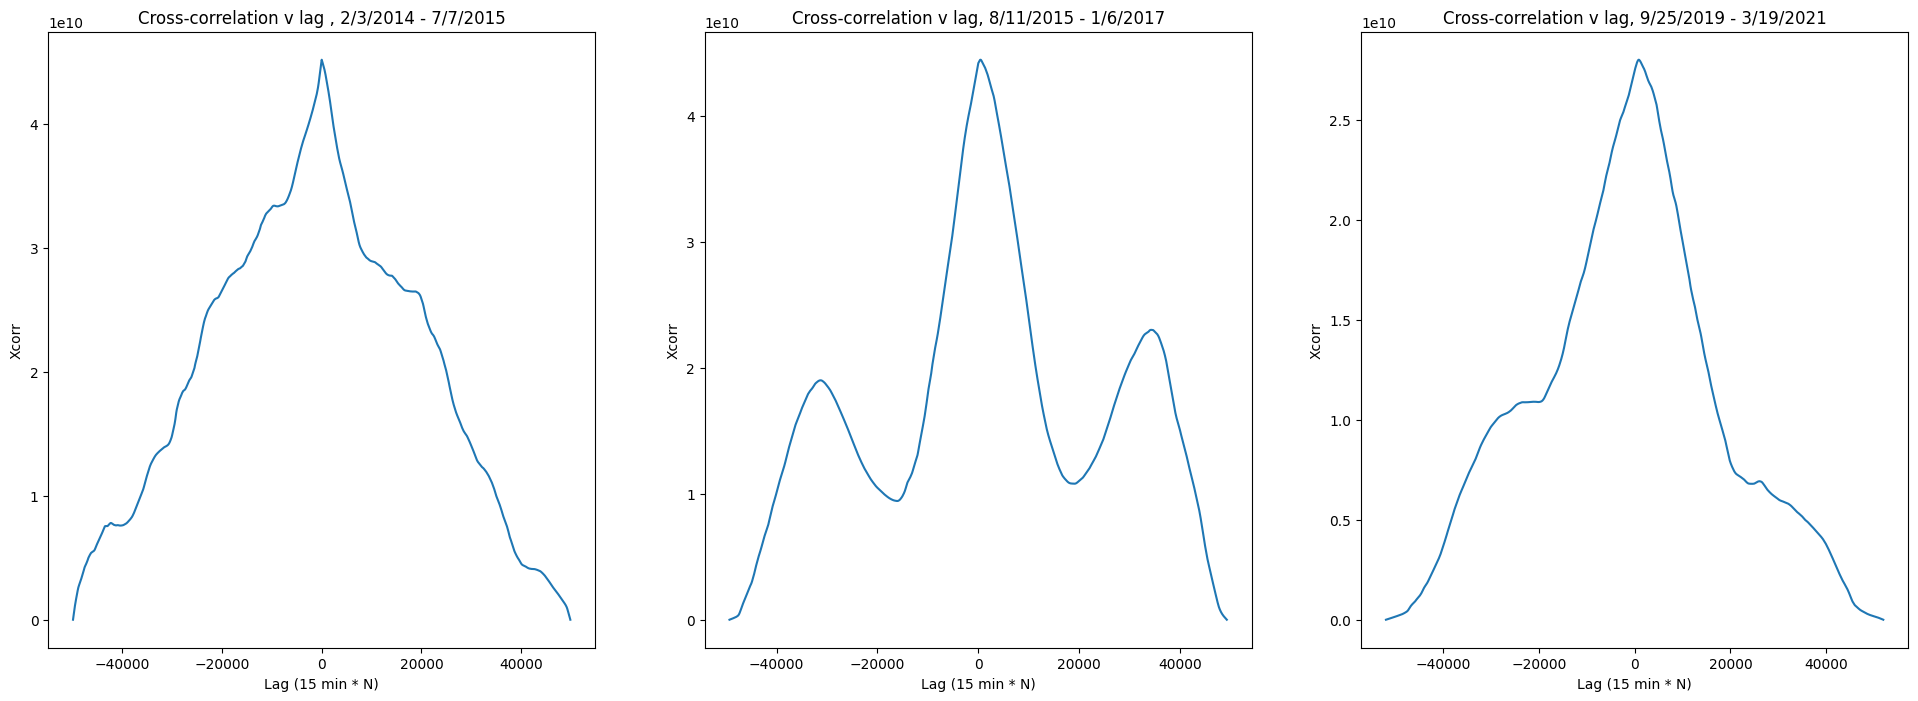

Lag of max cross-correlation for period 1 is 0.0 hours
Lag of max cross-correlation for period 2 is 115.75 hours
Lag of max cross-correlation for period 3 is 215.5 hours


In [24]:
#periods without gaps > 1 yr 
#2012-06-03 2014-01-24 but there are jer gaps here
#2014-02-03 2015-07-07
#2015-08-11 2017-01-06
#2019-07-16 2021-03-19 jer has a gap 2019-09-14 23:31:00', '2019-09-24 00:59:00'
#2019-09-25 2021-03-19
#find max lag for 2 periods of time where there are no gaps in salinity signal (a bit under 4 years for each)
hol2_1=hol2_dms_filt['Salinity[mS/cm]'].loc[datetime(2014,2,3):datetime(2015,7,7)].values
jp_1=jp_filt['Salinity[mS/cm]'].loc[datetime(2014,2,3):datetime(2015,7,7)].values
hol2_2=hol2_dms_filt['Salinity[mS/cm]'].loc[datetime(2015,8,11):datetime(2017,1,6)].values
jp_2=jp_filt['Salinity[mS/cm]'].loc[datetime(2015,8,11):datetime(2017,1,6)].values
hol2_3=hol2_dms_filt['Salinity[mS/cm]'].loc[datetime(2019,9,25):datetime(2021,3,19)].values
jp_3=jp_filt['Salinity[mS/cm]'].loc[datetime(2019,9,25):datetime(2021,3,19)].values

corr1 = correlate(hol2_1,jp_1)
lags1 = correlation_lags(len(hol2_1),len(jp_1))

corr2 = correlate(hol2_2,jp_2)
lags2 = correlation_lags(len(hol2_2),len(jp_2))

corr3 = correlate(hol2_3,jp_3)
lags3 = correlation_lags(len(hol2_3),len(jp_3))

fig, ax= plt.subplots(1,3,figsize=(24,8))
ax[0].plot(lags1,corr1)
ax[0].set_xlabel('Lag (15 min * N)')
ax[0].set_ylabel('Xcorr')
ax[0].set_title('Cross-correlation v lag , 2/3/2014 - 7/7/2015')

ax[1].plot(lags2,corr2)
ax[1].set_xlabel('Lag (15 min * N)')
ax[1].set_ylabel('Xcorr')
ax[1].set_title('Cross-correlation v lag, 8/11/2015 - 1/6/2017')

ax[2].plot(lags3,corr3)
ax[2].set_xlabel('Lag (15 min * N)')
ax[2].set_ylabel('Xcorr')
ax[2].set_title('Cross-correlation v lag, 9/25/2019 - 3/19/2021')

plt.show()
print('Lag of max cross-correlation for period 1 is '+ str(lags1[corr1.argmax()]*0.25)+ ' hours')
print('Lag of max cross-correlation for period 2 is '+ str(lags2[corr2.argmax()]*0.25)+ ' hours')
print('Lag of max cross-correlation for period 3 is '+ str(lags3[corr3.argmax()]*0.25)+ ' hours')

In [25]:
# #what about with the entire sequence? Use downsampled salinity
# corr = correlate(jp_f2020, pr_f2020)
# lags = correlation_lags(len(jp_f2020), len(pr_f2020))
# fig, ax= plt.subplots()
# ax.plot(lags,corr)
# ax.set_xlabel('Lag (30 min * N)')
# ax.set_ylabel('Xcorr')
# ax.set_title('Cross-correlation versus lag for Point Reyes NTR and Jersey Point salinity')
# plt.show()
# print('Lag of max cross-correlation is '+ str(lags[corr.argmax()]*0.5)+ ' hours')

In [26]:
# # What about holland cut and jersey point?
# corr = correlate(hol2_f2020, jp_f2020)
# lags = correlation_lags(len(hol2_f2020), len(jp_f2020))
# fig, ax= plt.subplots()
# ax.plot(lags,corr)
# ax.set_xlabel('Lag (30 min * N)')
# ax.set_ylabel('Xcorr')
# ax.set_title('Cross-correlation versus lag for Jersey Point and Holland Cut salinity')
# plt.show()
# print('Lag of max cross-correlation is '+ str(lags[corr.argmax()]*0.5)+ ' hours')

In [27]:
# #load the jersey point data, use the sjj signal to gap fill the jer, and load the holland cut salinity data, filter with cosine lanczos filter
# jer_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_jer.csv")
# jer_dms=jer_dms.rename(columns={"screened/jer//usbr/JER/ec/microS/cm": "Salinity[mS/cm]"})
# jer_dms['datetime']=pd.to_datetime(jer_dms['datetime'],format=dtformat)
# jer_dms.set_index("datetime",inplace=True)


# sjj_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_sjj.csv")
# sjj_dms=sjj_dms.rename(columns={"screened/sjj//usgs/11337190/ec/microS/cm": "Salinity[mS/cm]"})
# sjj_dms['datetime']=pd.to_datetime(sjj_dms['datetime'],format=dtformat)
# sjj_dms.set_index("datetime",inplace=True)

# #gapfill
# jp=jer_dms.fillna(sjj_dms)
# jp=jp.asfreq('15min')
# jp_filt=filter_timeseries(jp)

# hol2_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_hol2.csv")
# hol2_dms=hol2_dms.rename(columns={"screened/hol2//dwr_ncro/B95120/ec/microS/cm": "Salinity[mS/cm]"})
# hol2_dms['datetime']=pd.to_datetime(hol2_dms['datetime'],format=dtformat)
# hol2_dms.set_index("datetime",inplace=True)
# hol2_dms=hol2_dms.asfreq('15min')
# hol2_dms_filt=filter_timeseries(hol2_dms)


In [28]:
# #should not fill the gaps too many days
# # Does this change if we look at a longer signal and go back to the 15 minute version?
# hol2_x=hol2_dms_filt['Salinity[mS/cm]'].loc[datetime(2010,9,8):datetime(2024,8,28)].interpolate().values # need to fill the gaps to calculate the cross correlation
# jp_x=jp_filt['Salinity[mS/cm]'].loc[datetime(2010,9,8):datetime(2024,8,28)].interpolate().values
# corr = correlate(hol2_x, jp_x)
# lags = correlation_lags(len(hol2_x), len(jp_x))
# fig, ax= plt.subplots()
# ax.plot(lags,corr)
# ax.set_xlabel('Lag (15 min * N)')
# ax.set_ylabel('Xcorr')
# ax.set_title('Cross-correlation versus lag for Jersey Point and Holland Cut salinity')
# plt.show()
# print('Lag of max cross-correlation is '+ str(lags[corr.argmax()]*0.25)+ ' hours')

# Identify subtidal pumping events

In [29]:
#put all the variables in one array, need to cut it off before the last array begins (pr 2012-02-12) and before the first array ends (pr 2023-11-19)
df_raw=pd.concat([pr_filt.rename(columns={"Residual": "pr"}),jp_filt.rename(columns={"Salinity[mS/cm]": "jp"}),frk_filt.rename(columns={"Salinity[mS/cm]": "frk"}),hol2_dms_filt.rename(columns={"Salinity[mS/cm]": "hol2"})],axis=1)
df=df_raw.loc[datetime(2012,2,13):datetime(2023,11,18)]#.interpolate()

In [30]:
df

,pr,jp,frk,hol2
datetime,,,,
2012-02-13 00:00:00,0.084324,471.958898,NaN,497.825359
2012-02-13 00:15:00,NaN,471.996861,NaN,497.718607
2012-02-13 00:30:00,0.082788,472.032057,NaN,497.610584
2012-02-13 00:45:00,NaN,472.064334,NaN,497.501297
2012-02-13 01:00:00,0.081049,472.093539,NaN,497.390752
...,...,...,...,...
2023-11-17 23:00:00,0.206520,1067.342768,205.590816,216.022549
2023-11-17 23:15:00,NaN,1069.722160,205.787840,216.071901
2023-11-17 23:30:00,0.207101,1072.129574,205.988822,216.120777


In [31]:
df['datetime']=df.index.values
df['month']=df.index.month.values
df['year']=df.index.year.values
df

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a c

,pr,jp,frk,hol2,datetime,month,year
datetime,,,,,,,
2012-02-13 00:00:00,0.084324,471.958898,NaN,497.825359,2012-02-13 00:00:00,2,2012
2012-02-13 00:15:00,NaN,471.996861,NaN,497.718607,2012-02-13 00:15:00,2,2012
2012-02-13 00:30:00,0.082788,472.032057,NaN,497.610584,2012-02-13 00:30:00,2,2012
2012-02-13 00:45:00,NaN,472.064334,NaN,497.501297,2012-02-13 00:45:00,2,2012
2012-02-13 01:00:00,0.081049,472.093539,NaN,497.390752,2012-02-13 01:00:00,2,2012
...,...,...,...,...,...,...,...
2023-11-17 23:00:00,0.206520,1067.342768,205.590816,216.022549,2023-11-17 23:00:00,11,2023
2023-11-17 23:15:00,NaN,1069.722160,205.787840,216.071901,2023-11-17 23:15:00,11,2023
2023-11-17 23:30:00,0.207101,1072.129574,205.988822,216.120777,2023-11-17 23:30:00,11,2023


In [32]:
#I think I need to do this with a mask
#df.mask((df['A'] > 5) | (df['B'] < 3), 99)
# df_f_wo21=df.mask((df['month']<7) | (df['month']>11)|(df['year']==2021)|(df['year']==2022))
df_f_wo21=df.mask((df['month']<7) |(df['year']==2021)|(df['year']==2022)) #try leaving in december

In [33]:
maxw=60*24*4
minw=2
peakspr, propertiespr = find_peaks(df_f_wo21.pr.dropna().values, height=0,width=(2,maxw))

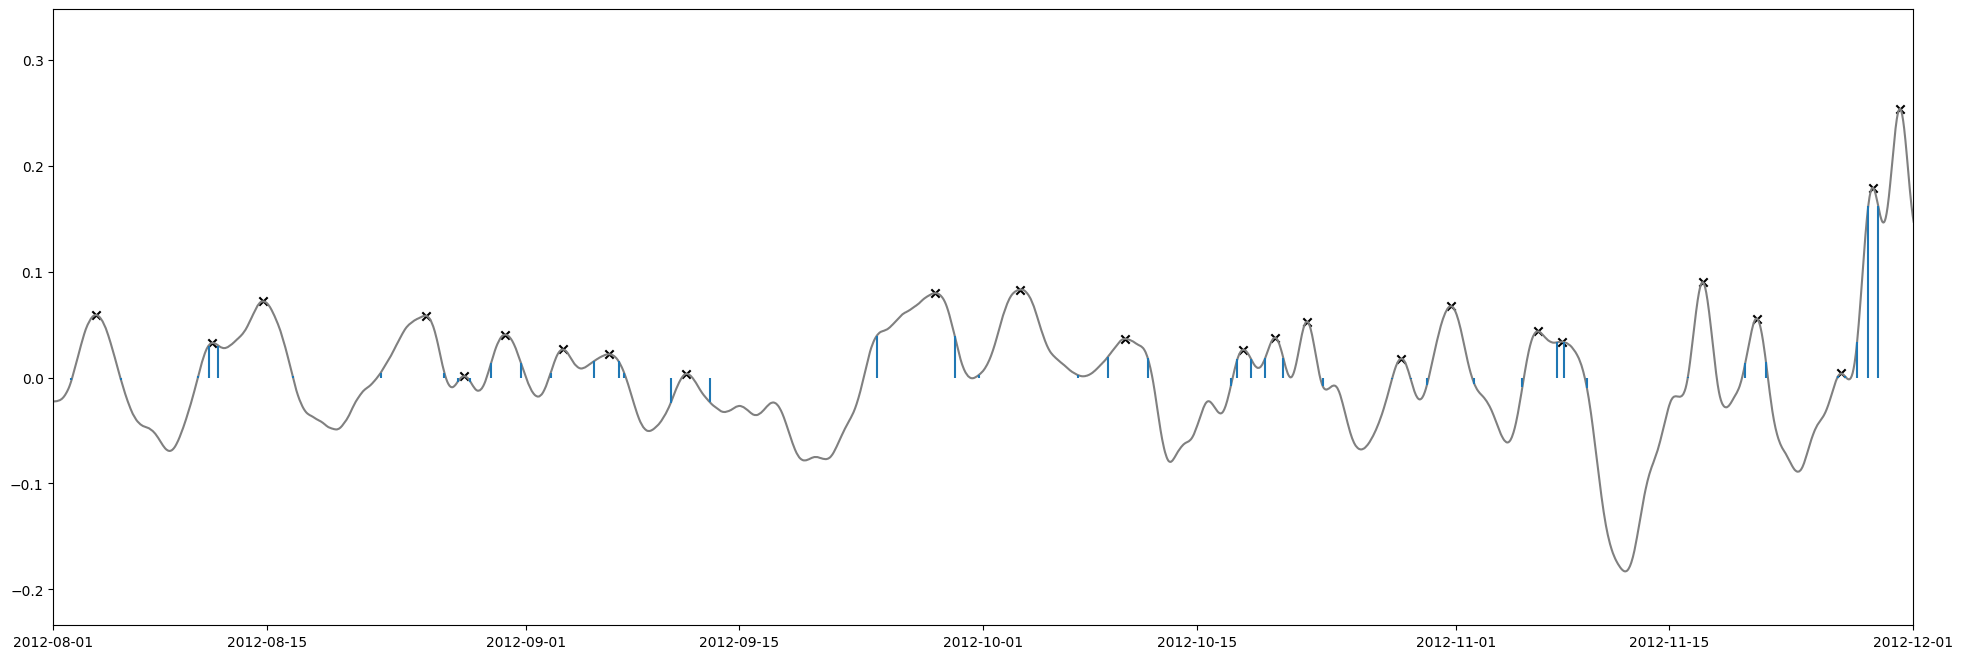

In [34]:
#calculate peak areas given the properties object from find_peaks
properties=propertiespr
y=df_f_wo21.pr.dropna().values
x=df_f_wo21.pr.dropna().index
left=properties["left_ips"]
right=properties["right_ips"]
lind=np.round(left).astype(int)
rind=np.round(right).astype(int)
fig,ax =plt.subplots(figsize=(24,8))
#ax.plot(x,y,color='grey')
ax.plot(x,y,color='grey')
ax.scatter(x[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
ax.vlines(x=x[rind],ymin=0,ymax=y[rind])

ax.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])
plt.show()

# function to calculate intensities

In [35]:
def unit_area(x,y,properties,peaks,dt,labelstr,peaksubset,plotflag):
    
    #where dt is the time resolution of x in hours
    if len(peaksubset)< len(peaks):
        peakidx=np.in1d(peaks,peaksubset)
    else:
        peakidx=np.arange(0,len(peaks))
    left=properties["left_ips"][peakidx]
    right=properties["right_ips"][peakidx]
    lind=np.round(left).astype(int)
    rind=np.round(right).astype(int)
    areav=np.array([])
    if plotflag==1:
        fig,ax =plt.subplots(figsize=(24,8))
        ax.plot(x,y,color='grey',linewidth=3)

    peaky=np.array([])
    
    for p in np.arange(0,len(lind)):
        #print(p)
        peak=y[lind[p]:rind[p]]
        peaky=np.append(peaky,np.max(peak))
        total_area = trapz(peak,dx=0.5) #need to pass the values between the left and right
        #now subtract the area from 0 to the peak, straight line between y[lind[p]] and y[rind[p]], should be the same length as peak
        n_points=len(peak)
        peak_bottom=np.linspace(peak[0],peak[len(peak)-1],num=n_points,endpoint=True)
        area_bottom=trapz(peak_bottom,dx=dt) #dx is half an hour
        area=total_area-area_bottom
        #print(area)
        areav=np.append(areav, area)
        #check that we are selecting the right area of the peak
        if plotflag==1:
            ax.plot(x[lind[p]:rind[p]],peak,linestyle='--',color='c',linewidth=3)
            ax.plot(x[lind[p]:rind[p]],peak_bottom,linestyle='--',color='m')
            ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
            ax.vlines(x=x[rind],ymin=0,ymax=y[rind])
        #30 minute time resolution = .5 hours
    dur=(rind-lind)*dt
    inten_u=areav/dur
    months_for_colors=x[lind].month
    print(len(peaksubset))
    print(len(peaky))
    if plotflag==1:
        ax.scatter(peaksubset,peaky,label=labelstr,marker="x",color='k',linewidth=2)
        #limit x axis to 1/5 of the time period
        ax.set_xlim([x[0],x[(np.rint(len(x)/10)).astype(int)]])
        plt.show()
    return inten_u, dur, months_for_colors #units of elevation in m X time in hours


In [36]:
(np.rint(len(x)/5)).astype(int)

17242

360
360


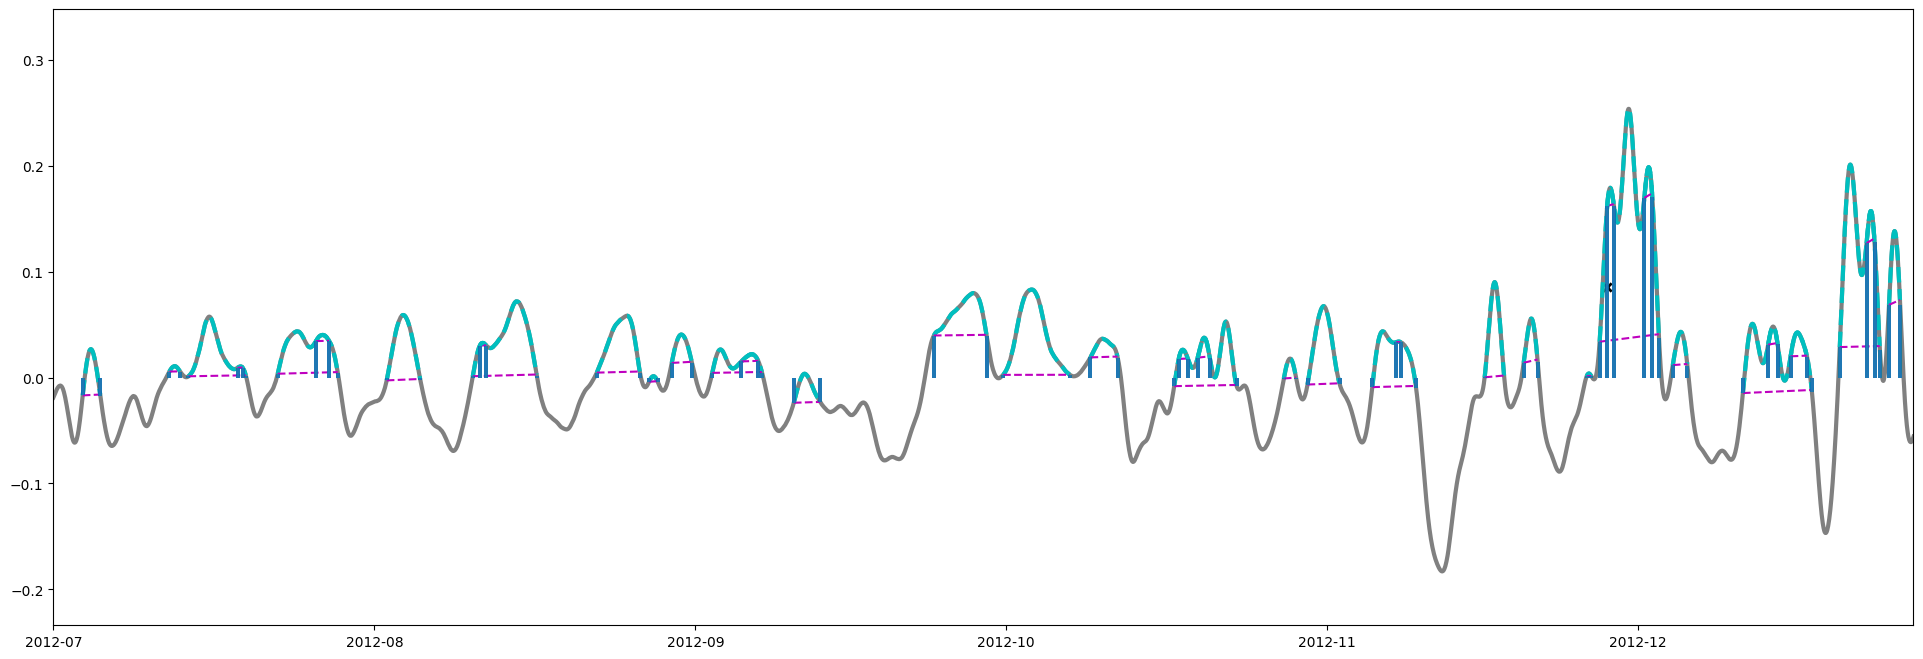

In [37]:
peakspr, propertiespr = find_peaks(df_f_wo21.pr.dropna().values, height=0,width=(2,maxw))
y=df_f_wo21.pr.dropna().values
x=df_f_wo21.pr.dropna().index
inten_u, dur, monthsforcolors = unit_area(x,y,propertiespr,peakspr,0.5,'pt reyes',peakspr,1)

# Before the function

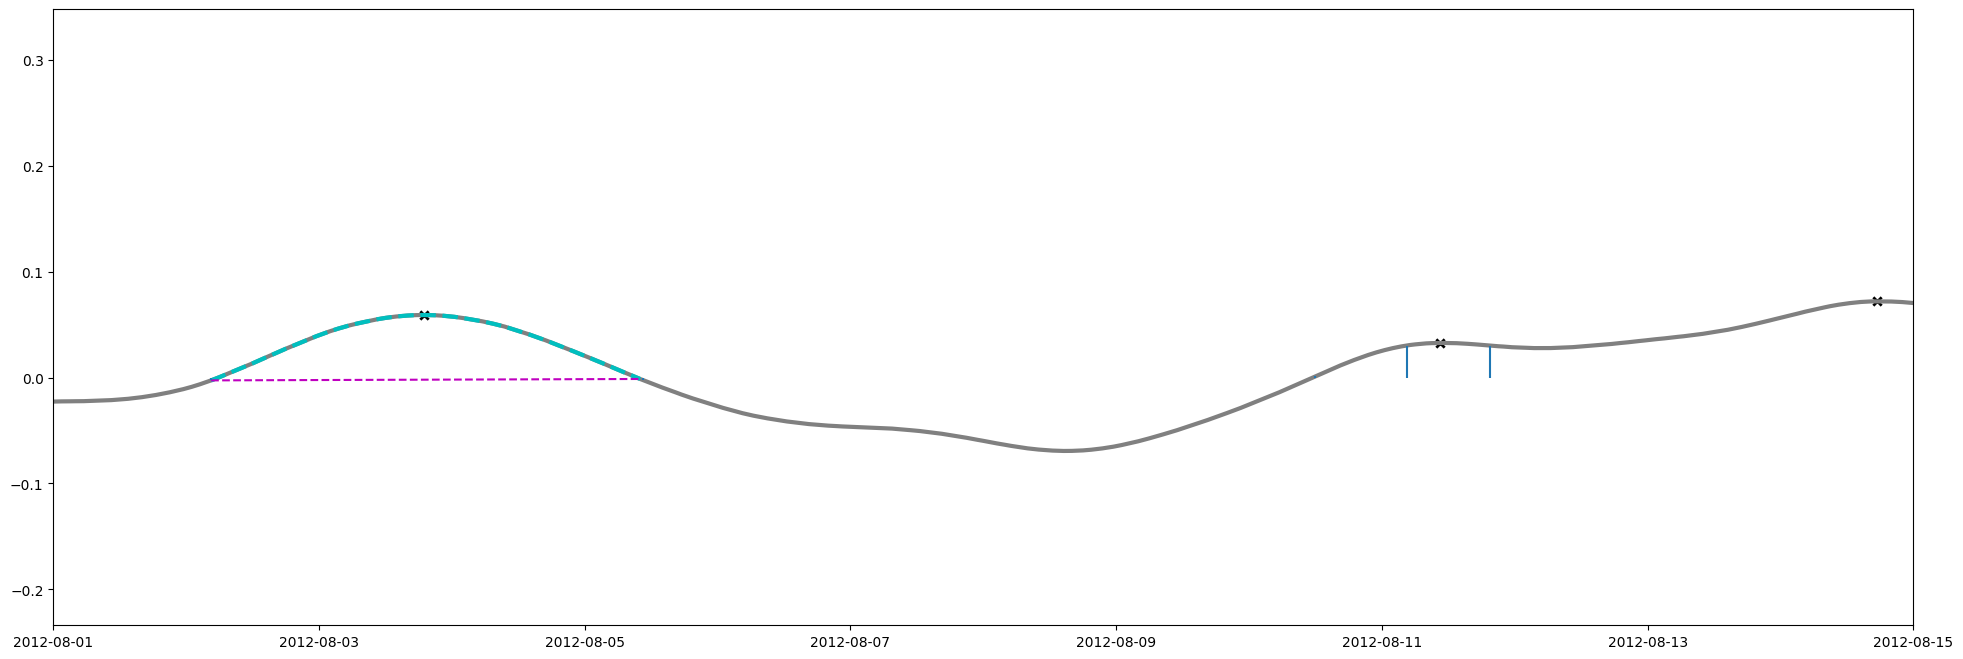

In [38]:
areav=np.array([])
p=6
if p==6:
#for p in np.arange(0,len(lind)):
    #print(p)
    peak=y[lind[p]:rind[p]]
    total_area = trapz(peak,dx=0.5) #need to pass the values between the left and right
    #now subtract the area from 0 to the peak, straight line between y[lind[p]] and y[rind[p]], should be the same length as peak
    n_points=len(peak)
    peak_bottom=np.linspace(peak[0],peak[len(peak)-1],num=n_points,endpoint=True)
    area_bottom=trapz(peak_bottom,dx=0.5) #dx is half an hour
    area=total_area-area_bottom
    #print(area)
    areav=np.append(areav, area)
    #30 minute time resolution = .5 hours
areav #units of elevation in m X time in hours
fig,ax =plt.subplots(figsize=(24,8))
#ax.plot(x,y,color='grey')
ax.plot(x,y,color='grey',linewidth=3)
#check that we are selecting the right area of the peak
ax.scatter(x[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k',linewidth=2)
ax.plot(x[lind[p]:rind[p]],peak,linestyle='--',color='c',linewidth=3)
ax.plot(x[lind[p]:rind[p]],peak_bottom,linestyle='--',color='m')
ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
ax.vlines(x=x[rind],ymin=0,ymax=y[rind])

ax.set_xlim([datetime(2012,8,1),datetime(2012,8,15)])
plt.show()

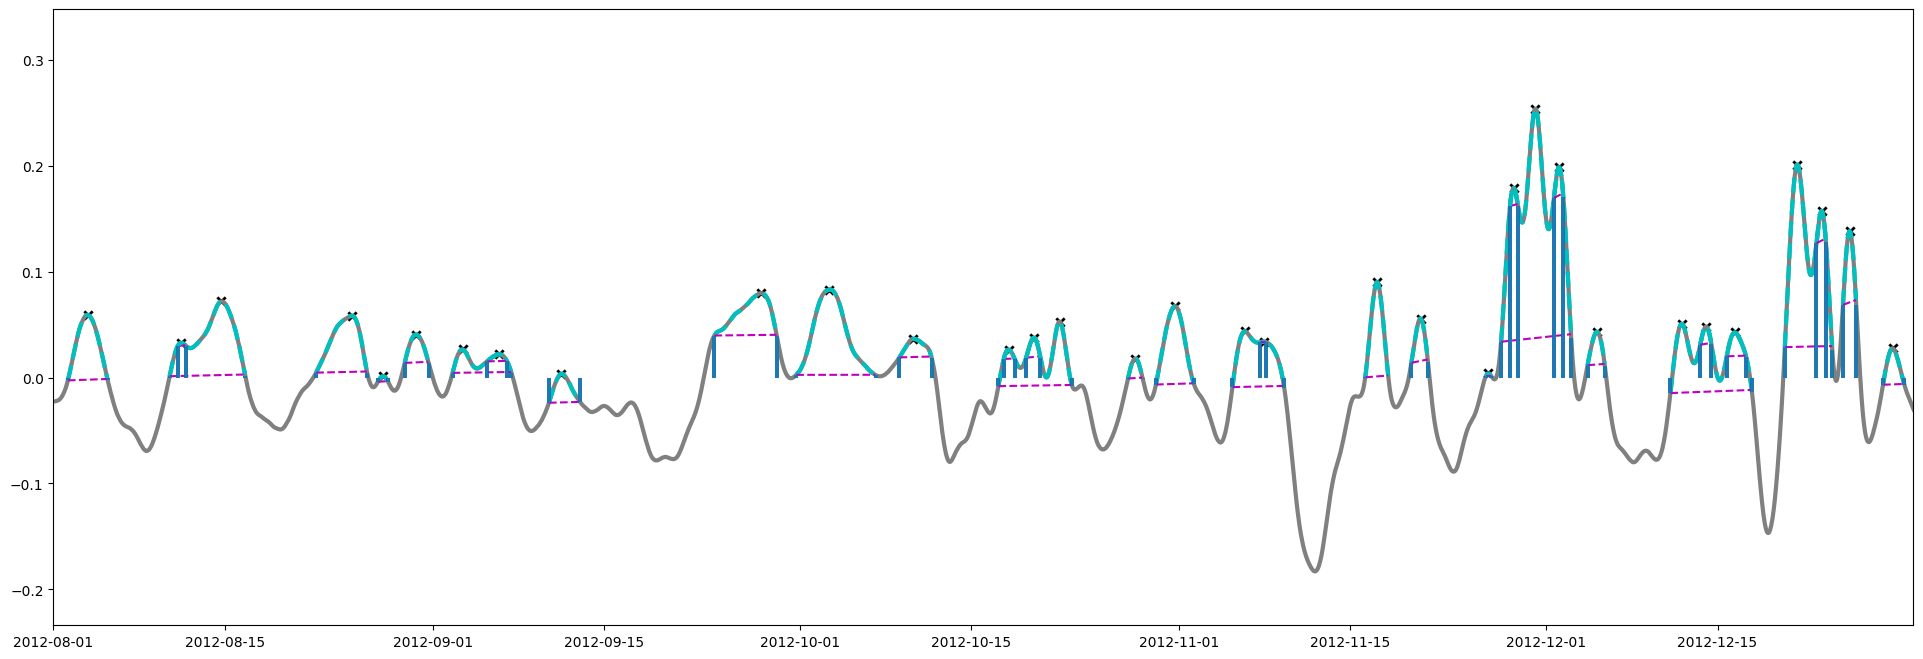

In [39]:
areav=np.array([])
fig,ax =plt.subplots(figsize=(24,8))
ax.plot(x,y,color='grey',linewidth=3)
ax.scatter(x[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k',linewidth=2)

for p in np.arange(0,len(lind)):
    #print(p)
    peak=y[lind[p]:rind[p]]
    total_area = trapz(peak,dx=0.5) #need to pass the values between the left and right
    #now subtract the area from 0 to the peak, straight line between y[lind[p]] and y[rind[p]], should be the same length as peak
    n_points=len(peak)
    peak_bottom=np.linspace(peak[0],peak[len(peak)-1],num=n_points,endpoint=True)
    area_bottom=trapz(peak_bottom,dx=0.5) #dx is half an hour
    area=total_area-area_bottom
    #print(area)
    areav=np.append(areav, area)
    #check that we are selecting the right area of the peak
    ax.plot(x[lind[p]:rind[p]],peak,linestyle='--',color='c',linewidth=3)
    ax.plot(x[lind[p]:rind[p]],peak_bottom,linestyle='--',color='m')
    ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
    ax.vlines(x=x[rind],ymin=0,ymax=y[rind])
    #30 minute time resolution = .5 hours
areav #units of elevation in m X time in hours


ax.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])
plt.show()

In [40]:
#calculate duration of events
dur=(rind-lind)*0.5 #duration in hours
dur

array([ 41. ,  25. , 133.5,  12. , 139.5,  31. ,  78. ,  15. , 148.5,
       100. ,  20. ,  47. , 115.5,  39.5,  61.5, 122.5, 155.5,  63. ,
        21.5,  28. , 144.5,  29. ,  74.5, 101.5,  11. ,  45.5,  32.5,
        11. ,  15.5, 137.5,  18.5,  34. , 160. ,  22. ,  38. ,  93. ,
        18.5,  26. ,  42. ,   3.5, 161. ,  39. ,  22.5,  35.5,  69.5,
       106.5,  24.5,  13. , 175.5,  10.5,  58.5, 177.5,  13. ,   4. ,
        96.5,   8. , 107. ,   5. , 119.5,  41.5,  64. ,  28. ,  16.5,
       129.5,  11. ,  37. , 112. ,  20.5,  66.5,  32. , 106. ,  16. ,
         5. , 126. ,  36. ,  13. , 129. , 133. ,   1.5,  14.5,  13.5,
       361.5,  37.5,  39.5,  41.5,  12. , 280.5,  70. ,  11.5,  91.5,
        12. , 139. ,  20.5,  46. , 218. ,  15.5,  34. ,  34. ,  59.5,
       131. ,  17.5,  98.5,   4. ,  38. ,  47.5,  15.5,  36. ,  63.5,
        73. ,   9.5,  11. ,  59.5,   8.5, 122. ,  99.5,  38.5,  16.5,
       178.5,  21. ,  59. , 171.5,  51.5,  66. , 295. ,  10.5,  67. ,
        24.5,   8. ,

In [41]:
#normalize area by duration (unit intensity)
inten_u=areav/dur

Text(0.5, 1.0, 'Event unit intensity (h*m/h)')

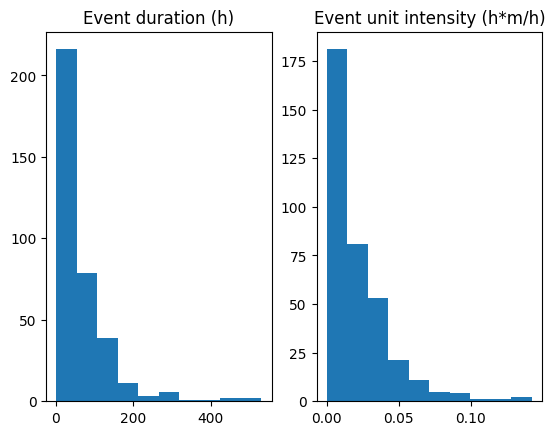

In [42]:
#first make duration and intensity histograms
fig, ax = plt.subplots(1,2)

ax[0].hist(dur)
ax[0].set_title('Event duration (h)')
ax[1].hist(inten_u)
ax[1].set_title('Event unit intensity (h*m/h)')


Text(0, 0.5, 'event unit intensity (h*m/h)')

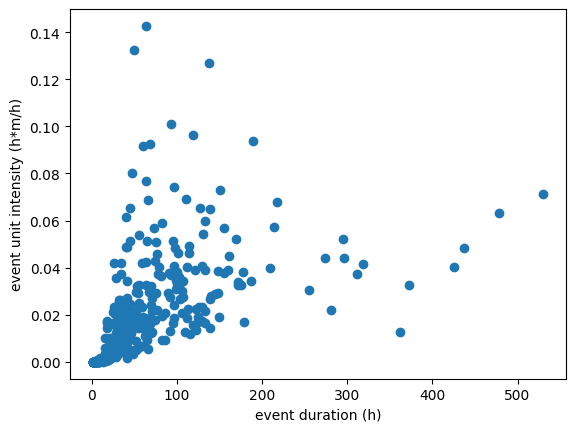

In [43]:
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur,inten_u)
ax.set_xlabel('event duration (h)')
ax.set_ylabel('event unit intensity (h*m/h)')

Text(0, 0.5, 'event unit intensity (h*m/h)')

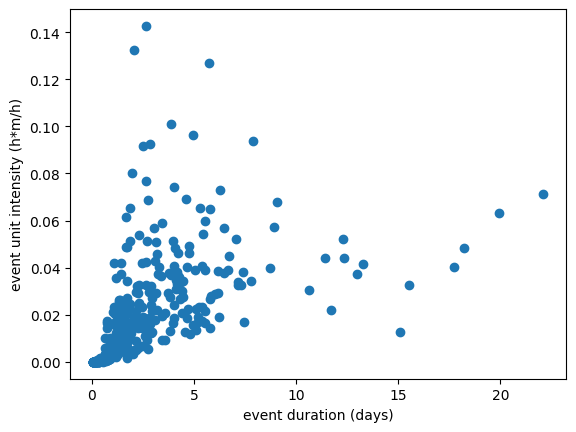

In [44]:
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur/24,inten_u)
ax.set_xlabel('event duration (days)')
ax.set_ylabel('event unit intensity (h*m/h)')

(0.0, 20.0)

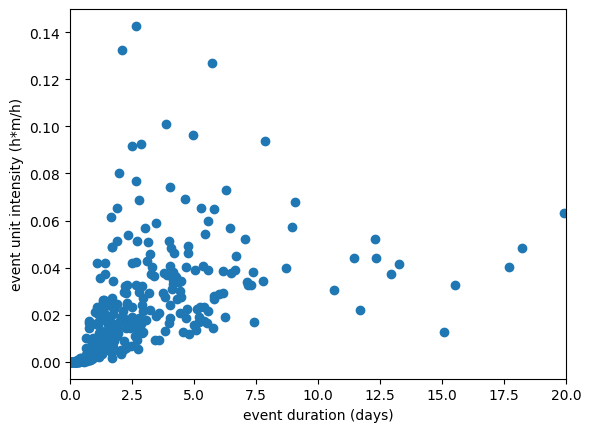

In [45]:
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur/24,inten_u)
ax.set_xlabel('event duration (days)')
ax.set_ylabel('event unit intensity (h*m/h)')
ax.set_xlim(0,20)

In [46]:
#partition by month, need cyclical color map
# actually because we are trimming the year to start in the summer does not make sense to do cylical
# first need to map the index to a date
# then extract month 
x[lind].month

Int64Index([ 7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
            ...
            10, 10, 10, 10, 10, 10, 10, 10, 10, 11],
           dtype='int64', name='datetime', length=360)

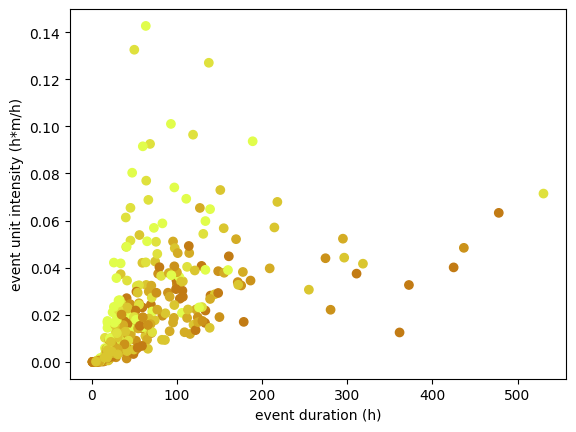

In [47]:
#cmocean phase is cyclical!
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur,inten_u, color=cmocean.cm.solar(x[lind].month/12))
ax.set_xlabel('event duration (h)')
ax.set_ylabel('event unit intensity (h*m/h)')
plt.show()

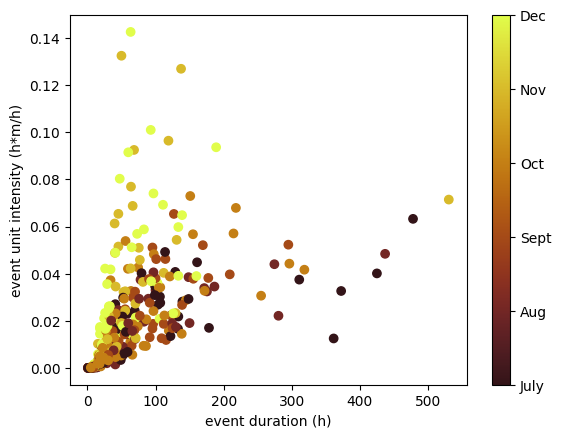

In [48]:
#add colorbar

fig, ax = plt.subplots()

pts=ax.scatter(dur,inten_u,c=x[lind].month,cmap=cmocean.cm.solar)
ax.set_xlabel('event duration (h)')
ax.set_ylabel('event unit intensity (h*m/h)')
cbar=fig.colorbar(pts, ax=ax)
cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])
plt.show()

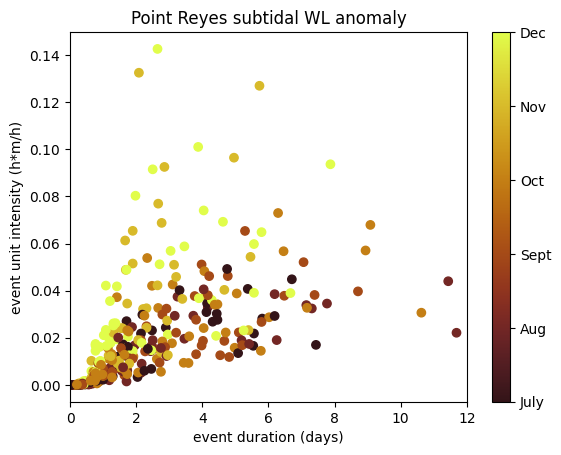

In [49]:
fig, ax = plt.subplots()

pts=ax.scatter(dur/24,inten_u,c=x[lind].month,cmap=cmocean.cm.solar)
ax.set_xlabel('event duration (days)')
ax.set_ylabel('event unit intensity (h*m/h)')
ax.set_xlim(0,12)
ax.set_title('Point Reyes subtidal WL anomaly')
cbar=fig.colorbar(pts, ax=ax)
cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])
plt.show()

# Is the distribution the same for salinity at Jersey Point?

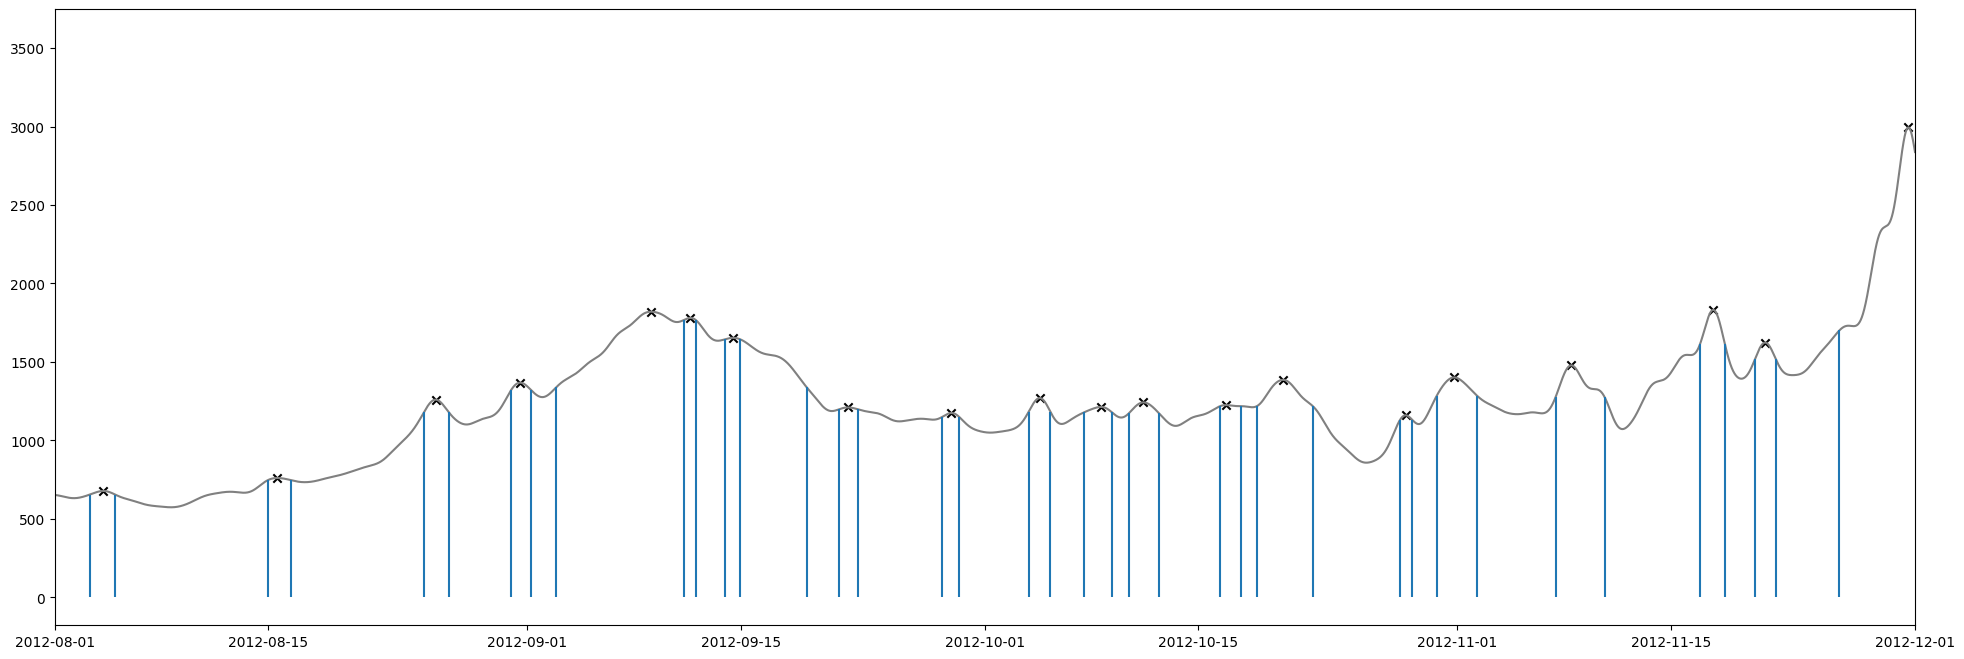

In [50]:
peaksjp, propertiesjp = find_peaks(df_f_wo21.jp.dropna().values, prominence=10,width=(0,maxw)) #need to pass range of widths or won't be able to extract left and right
y=df_f_wo21.jp.dropna().values
x=df_f_wo21.jp.dropna().index
left=propertiesjp["left_ips"]
right=propertiesjp["right_ips"]
lind=np.round(left).astype(int)
rind=np.round(right).astype(int)
fig,ax =plt.subplots(figsize=(24,8))
#ax.plot(x,y,color='grey')
ax.plot(x,y,color='grey')
ax.scatter(x[peaksjp], y[peaksjp], label="Jersey Point",marker="x",color='k')
ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
ax.vlines(x=x[rind],ymin=0,ymax=y[rind])

ax.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])
plt.show()

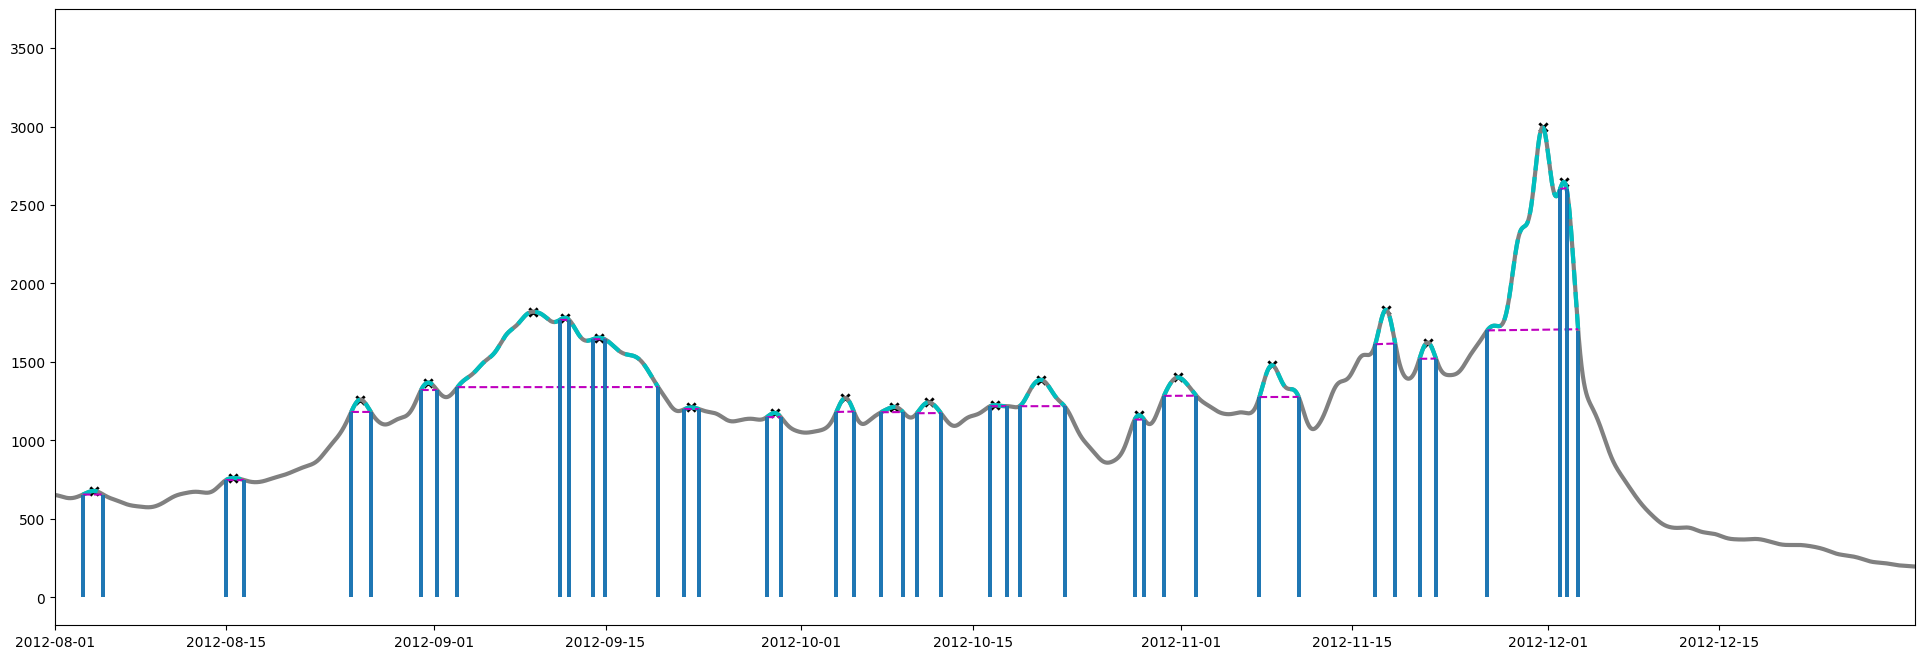

In [51]:
areav=np.array([])
fig,ax =plt.subplots(figsize=(24,8))
ax.plot(x,y,color='grey',linewidth=3)
ax.scatter(x[peaksjp], df_f_wo21.jp.dropna().iloc[peaksjp], label="Jersey Point",marker="x",color='k',linewidth=2)

for p in np.arange(0,len(lind)):
    #print(p)
    peak=y[lind[p]:rind[p]]
    total_area = trapz(peak,dx=0.25) #need to pass the values between the left and right
    #now subtract the area from 0 to the peak, straight line between y[lind[p]] and y[rind[p]], should be the same length as peak
    n_points=len(peak)
    peak_bottom=np.linspace(peak[0],peak[len(peak)-1],num=n_points,endpoint=True)
    area_bottom=trapz(peak_bottom,dx=0.25) #dx is half an hour
    area=total_area-area_bottom
    #print(area)
    areav=np.append(areav, area)
    #check that we are selecting the right area of the peak
    ax.plot(x[lind[p]:rind[p]],peak,linestyle='--',color='c',linewidth=3)
    ax.plot(x[lind[p]:rind[p]],peak_bottom,linestyle='--',color='m')
    ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
    ax.vlines(x=x[rind],ymin=0,ymax=y[rind])
    #30 minute time resolution = .5 hours
areav #units of elevation in m X time in hours


ax.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])
plt.show()

In [52]:
#calculate duration of events
dur=(rind-lind)*0.25 #duration in hours
#normalize area by duration (unit intensity)
inten_u=areav/dur


Text(0, 0.5, 'event unit intensity ($h*mS/cm^3 h^{-1}$)')

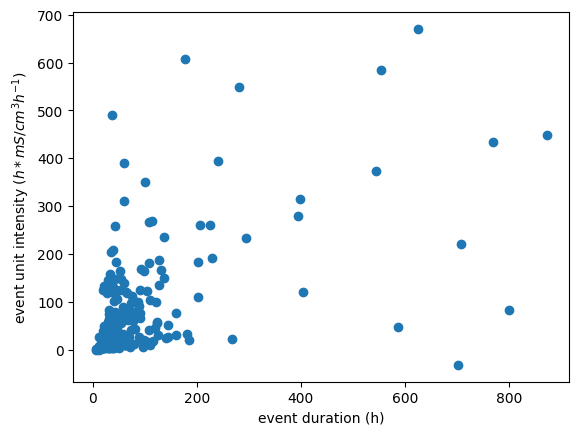

In [53]:
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur,inten_u)
ax.set_xlabel('event duration (h)')
ax.set_ylabel('event unit intensity ($h*mS/cm^3 h^{-1}$)')

(0.0, 20.0)

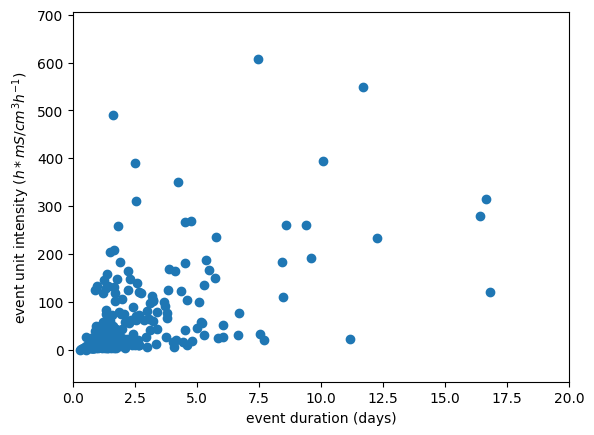

In [54]:
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur/24,inten_u)
ax.set_xlabel('event duration (days)')
ax.set_ylabel('event unit intensity ($h*mS/cm^3 h^{-1}$)')
ax.set_xlim(0,20)

(0.0, 8.0)

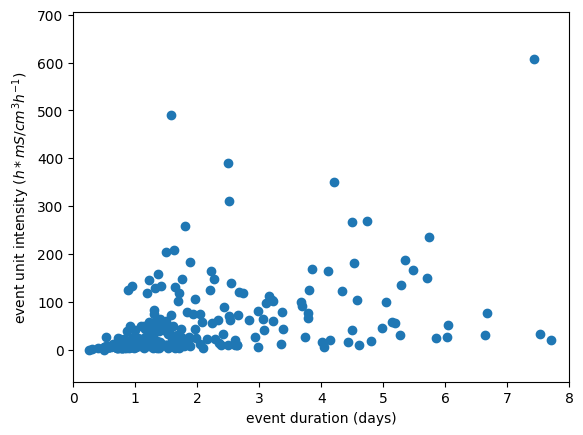

In [55]:
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur/24,inten_u)
ax.set_xlabel('event duration (days)')
ax.set_ylabel('event unit intensity ($h*mS/cm^3 h^{-1}$)')
ax.set_xlim(0,8)

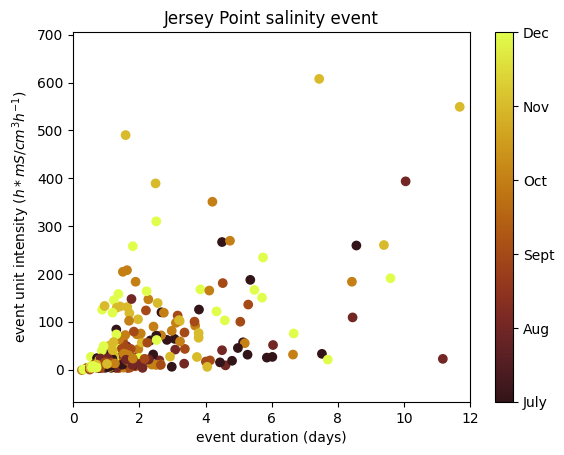

In [56]:
#add colorbar
fig, ax = plt.subplots()

pts=ax.scatter(dur/24,inten_u,c=x[lind].month,cmap=cmocean.cm.solar)
ax.set_xlabel('event duration (days)')
ax.set_ylabel('event unit intensity ($h*mS/cm^3 h^{-1}$)')
ax.set_xlim(0,12)
ax.set_title('Jersey Point salinity event')
cbar=fig.colorbar(pts, ax=ax)
cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])
plt.show()

In [57]:
#for each event duration bin, fit a cdf for frequency versus intensity 


In [58]:
#make intensity duration frequency plot


# try finding peaks with wavelet transform function instead (actually this function does not find the widths of the events)

In [59]:
wtwidths=np.linspace(2,maxw)

In [60]:
wtwidths

array([2.00000000e+00, 1.19510204e+02, 2.37020408e+02, 3.54530612e+02,
       4.72040816e+02, 5.89551020e+02, 7.07061224e+02, 8.24571429e+02,
       9.42081633e+02, 1.05959184e+03, 1.17710204e+03, 1.29461224e+03,
       1.41212245e+03, 1.52963265e+03, 1.64714286e+03, 1.76465306e+03,
       1.88216327e+03, 1.99967347e+03, 2.11718367e+03, 2.23469388e+03,
       2.35220408e+03, 2.46971429e+03, 2.58722449e+03, 2.70473469e+03,
       2.82224490e+03, 2.93975510e+03, 3.05726531e+03, 3.17477551e+03,
       3.29228571e+03, 3.40979592e+03, 3.52730612e+03, 3.64481633e+03,
       3.76232653e+03, 3.87983673e+03, 3.99734694e+03, 4.11485714e+03,
       4.23236735e+03, 4.34987755e+03, 4.46738776e+03, 4.58489796e+03,
       4.70240816e+03, 4.81991837e+03, 4.93742857e+03, 5.05493878e+03,
       5.17244898e+03, 5.28995918e+03, 5.40746939e+03, 5.52497959e+03,
       5.64248980e+03, 5.76000000e+03])

In [61]:
# wtwidths=np.linspace(2,maxw)
# wtpeakspr = find_peaks_cwt(df_f_wo21.pr.dropna().values,wtwidths)

# y=df_f_wo21.pr.dropna().values
# x=df_f_wo21.pr.dropna().index
# left=wtpropertiespr["left_ips"]
# right=wtpropertiespr["right_ips"]
# lind=np.round(left).astype(int)
# rind=np.round(right).astype(int)
# fig,ax =plt.subplots(figsize=(24,8))
# #ax.plot(x,y,color='grey')
# ax.plot(x,y,color='grey')
# ax.scatter(x[wtpeakspr], df_f_wo21.pr.dropna().iloc[wtpeakspr], label="Point Reyes",marker="x",color='k')
# ax.set_title('wavelet transform')
# ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
# ax.vlines(x=x[rind],ymin=0,ymax=y[rind])

# ax.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])
# plt.show()

In [62]:
# areavwt=np.array([])
# fig,ax =plt.subplots(figsize=(24,8))
# ax.plot(x,y,color='grey',linewidth=3)
# ax.scatter(x[wtpeakspr], df_f_wo21.pr.dropna().iloc[wtpeakspr], label="Point Reyes",marker="x",color='k',linewidth=2)

# for p in np.arange(0,len(lind)):
#     #print(p)
#     peak=y[lind[p]:rind[p]]
#     total_area = trapz(peak,dx=0.5) #need to pass the values between the left and right
#     #now subtract the area from 0 to the peak, straight line between y[lind[p]] and y[rind[p]], should be the same length as peak
#     n_points=len(peak)
#     peak_bottom=np.linspace(peak[0],peak[len(peak)-1],num=n_points,endpoint=True)
#     area_bottom=trapz(peak_bottom,dx=0.5) #dx is half an hour
#     area=total_area-area_bottom
#     #print(area)
#     areav=np.append(areav, area)
#     #check that we are selecting the right area of the peak
#     ax.plot(x[lind[p]:rind[p]],peak,linestyle='--',color='c',linewidth=3)
#     ax.plot(x[lind[p]:rind[p]],peak_bottom,linestyle='--',color='m')
#     ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
#     ax.vlines(x=x[rind],ymin=0,ymax=y[rind])
#     #30 minute time resolution = .5 hours
# areavwt #units of elevation in m X time in hours


# ax.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])
# plt.show()

In [63]:
# np.rint(lind).astype(int)

# Finding events based on multiple criteria

In [64]:
#control on min and max length of event
maxw=60*24*4
minw=2

#max time lag to search between locations

In [65]:
#first find the datetimes with peaks at all locations, store them in logical columns e.g. pr_peak
#seems to be using the whole summer as a peak sometimes, set max width of 2 months 

peakspr, propertiespr = find_peaks(df_f_wo21.pr.dropna().values, height=0,width=(2,maxw))#,width=(0,maxw)) #this just gives the x locations of the peaks, need to convert to logical
pr_indices = df_f_wo21.pr.dropna().index
peaksjp, propertiesjp = find_peaks(df_f_wo21.jp.dropna().values, prominence=10,width=(0,maxw))
jp_indices = df_f_wo21.jp.dropna().index
peakshol2, propertieshol2 = find_peaks(df_f_wo21.hol2.dropna().values, prominence=5,width=(0,maxw))
hol2_indices = df_f_wo21.hol2.dropna().index
peaksfrk, propertiesfrk = find_peaks(df_f_wo21.frk.dropna().values, prominence=5,width=(0,maxw))
frk_indices = df_f_wo21.frk.dropna().index
#peakshol210, _ = find_peaks(df_f_wo21.hol2.values, prominence=10)
idx=np.arange(0,len(df_f_wo21.pr.values))#has the same shape as the first argument
df_f_wo21['pr_peak']=np.isin(df_f_wo21.index,pr_indices[peakspr]) #for this one need to map from the nan dropped list to full list
df_f_wo21['jp_peak']=np.isin(df_f_wo21.index,jp_indices[peaksjp])
df_f_wo21['hol2_peak']=np.isin(df_f_wo21.index,hol2_indices[peakshol2])
df_f_wo21['frk_peak']=np.isin(df_f_wo21.index,frk_indices[peaksfrk])
df_f_wo21

,pr,jp,frk,hol2,datetime,month,year,pr_peak,jp_peak,hol2_peak,frk_peak
datetime,,,,,,,,,,,
2012-02-13 00:00:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 00:15:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 00:30:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 00:45:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 01:00:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17 23:00:00,0.206520,1067.342768,205.590816,216.022549,2023-11-17 23:00:00,11.0,2023.0,False,False,False,False
2023-11-17 23:15:00,NaN,1069.722160,205.787840,216.071901,2023-11-17 23:15:00,11.0,2023.0,False,False,False,False
2023-11-17 23:30:00,0.207101,1072.129574,205.988822,216.120777,2023-11-17 23:30:00,11.0,2023.0,False,False,False,False


In [66]:
print(df_f_wo21['pr_peak'].sum())
print(df_f_wo21['jp_peak'].sum())
print(df_f_wo21['frk_peak'].sum())
print(df_f_wo21['hol2_peak'].sum())

360
289
82
153


In [67]:
#make an array of ones to multiply by the true false
ov=np.ones_like(df_f_wo21['pr_peak'].values)

In [68]:
# as a first pass, how many events are there where there is a true value in all columns in the 24 hours after the pr peak?
peak_pr24h=np.datetime64()
peak_jp24h=np.datetime64()
peak_hol224h=np.datetime64()

win=24 #number of samples in 24 hours
winh=win*5
count_j=0
count_h=0
for p in peakspr:
    #need to map this index back to the data frame
    x=pr_indices[p]
    x2=x+pd.Timedelta(hours=win)
    x3=x+pd.Timedelta(hours=winh)
    if df_f_wo21.jp_peak[x:x2].sum()>0:
        count_j=count_j+1
        if df_f_wo21.hol2_peak[x:x3].sum()>0:  
            count_h=count_h+1
            peak_pr24h=np.append(peak_pr24h,x.to_datetime64())
            #these should be in real time (don't drop na)
            peak_jp24h=np.append(peak_jp24h,(x+pd.Timedelta(minutes=df_f_wo21.jp_peak[x:x2].argmax()*15)).to_datetime64())
            peak_hol224h=np.append(peak_hol224h,(x+pd.Timedelta(minutes=df_f_wo21.hol2_peak[x:x3].argmax()*15)).to_datetime64())
idx=np.arange(0,len(df_f_wo21.pr.values))
print(len(peak_pr24h))
print(count_j)
print(count_h)
df_f_wo21['all_peak_24h']=np.isin(idx,peak_pr24h)

60
141
59


In [69]:
#trim the NaT from the beginning of the arrays
peak_pr24h=peak_pr24h[1:]
peak_jp24h=peak_jp24h[1:]
peak_hol224h=peak_hol224h[1:]

# Plotting the linked events 

In [70]:
peakidx=np.in1d(pr_indices[peakspr],peak_pr24h)

In [71]:
len(propertiespr["left_ips"][peakidx])

59

(15553.0, 15675.0)

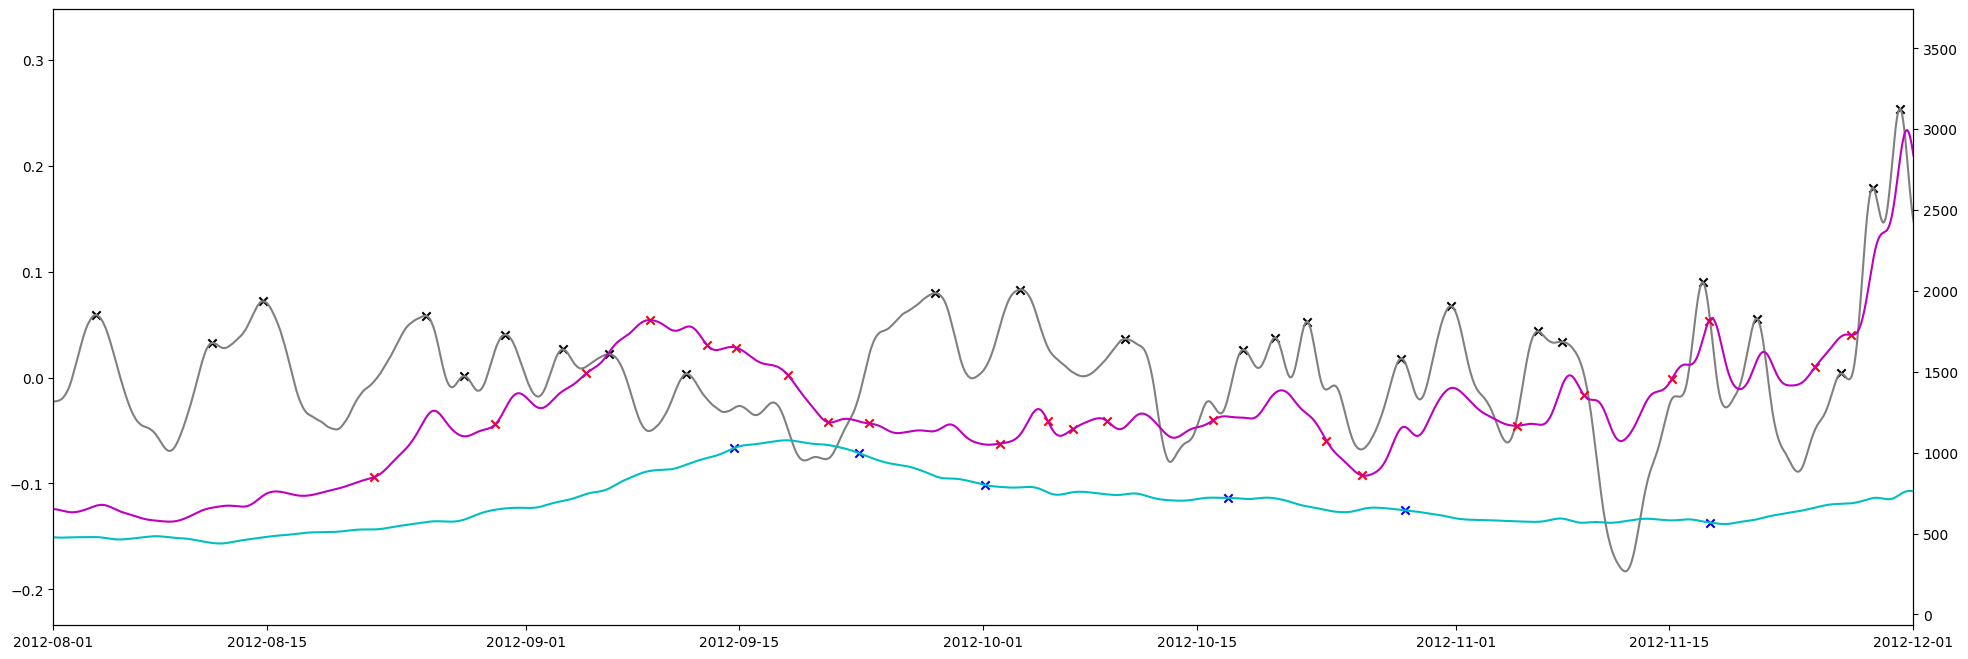

In [72]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.iloc[peaksjp],df_f_wo21.jp.iloc[peaksjp],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.iloc[peakshol2],df_f_wo21.hol2.iloc[peakshol2],label="Holland Cut",marker="x",color='b')
ax.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])
ax1.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])

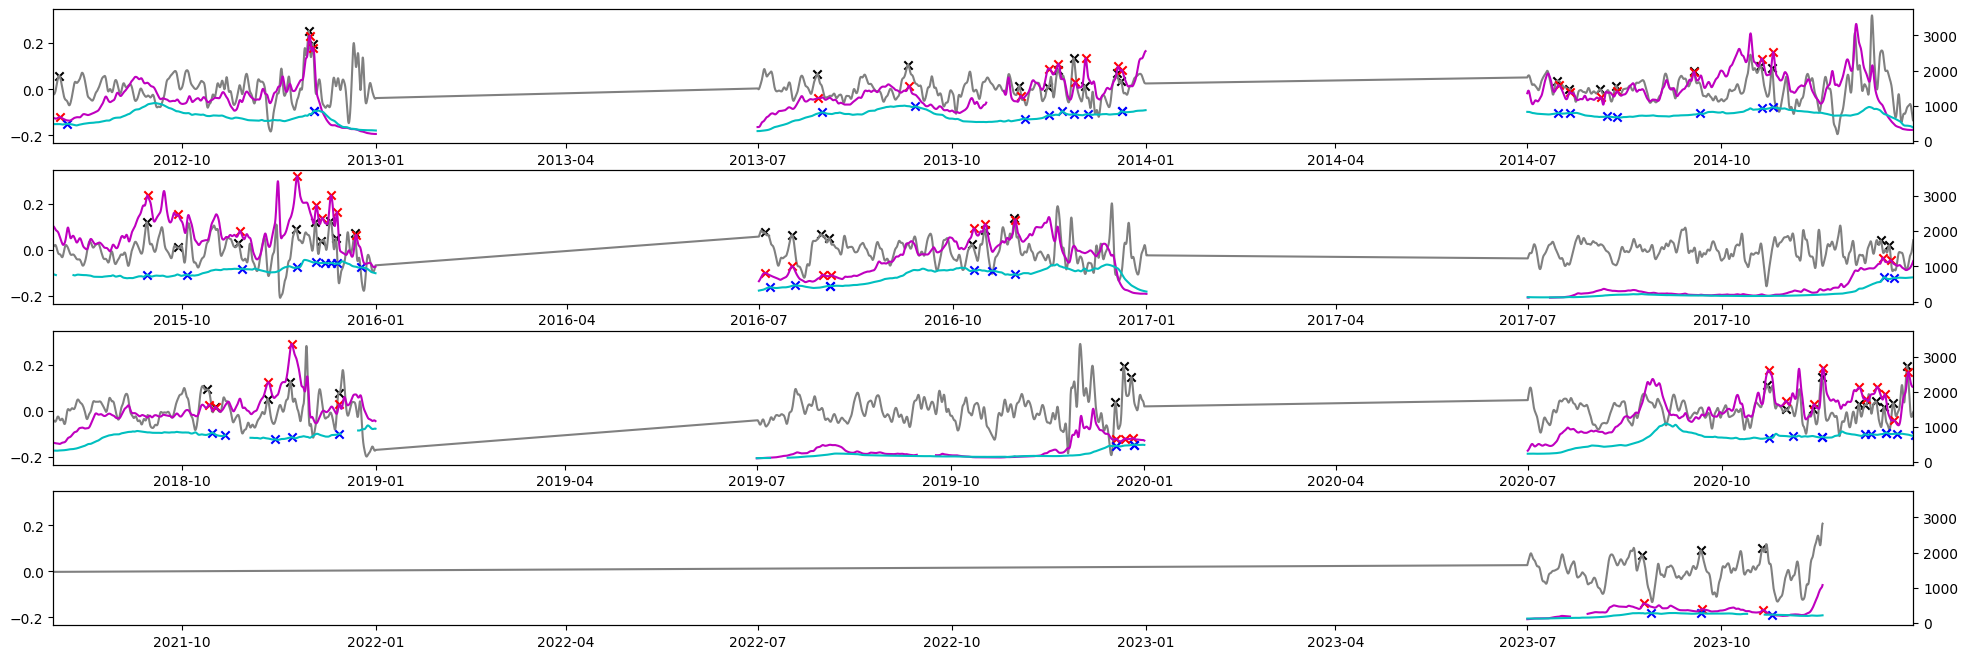

In [73]:
# try plotting these 19 events, split the period of time into 4 sections
fig, ax =plt.subplots(4,1,sharey=True,figsize=(24,8))

ax[0].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[0].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax1=ax[0].twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],label="Holland Cut",marker="x",color='b')
ax[0].set_xlim([datetime(2012,8,1),datetime(2014,12,31)])
ax1.set_xlim([datetime(2012,8,1),datetime(2014,12,31)])

ax[1].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[1].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax2=ax[1].twinx()
ax2.plot(df_f_wo21.jp,color='m')
ax2.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax2.plot(df_f_wo21.hol2,color='c')
ax2.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],label="Holland Cut",marker="x",color='b')
ax[1].set_xlim([datetime(2015,8,1),datetime(2017,12,31)])
ax2.set_xlim([datetime(2015,8,1),datetime(2017,12,31)])

ax[2].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[2].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax3=ax[2].twinx()
ax3.plot(df_f_wo21.jp,color='m')
ax3.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax3.plot(df_f_wo21.hol2,color='c')
ax3.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],label="Holland Cut",marker="x",color='b')
ax[2].set_xlim([datetime(2018,8,1),datetime(2020,12,31)])
ax3.set_xlim([datetime(2018,8,1),datetime(2020,12,31)])

ax[3].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[3].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax4=ax[3].twinx()
ax4.plot(df_f_wo21.jp,color='m')
ax4.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax4.plot(df_f_wo21.hol2,color='c')
ax4.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],label="Holland Cut",marker="x",color='b')
ax[3].set_xlim([datetime(2021,8,1),datetime(2023,12,31)])
ax4.set_xlim([datetime(2021,8,1),datetime(2023,12,31)])

plt.show()

(16648.0, 16800.0)

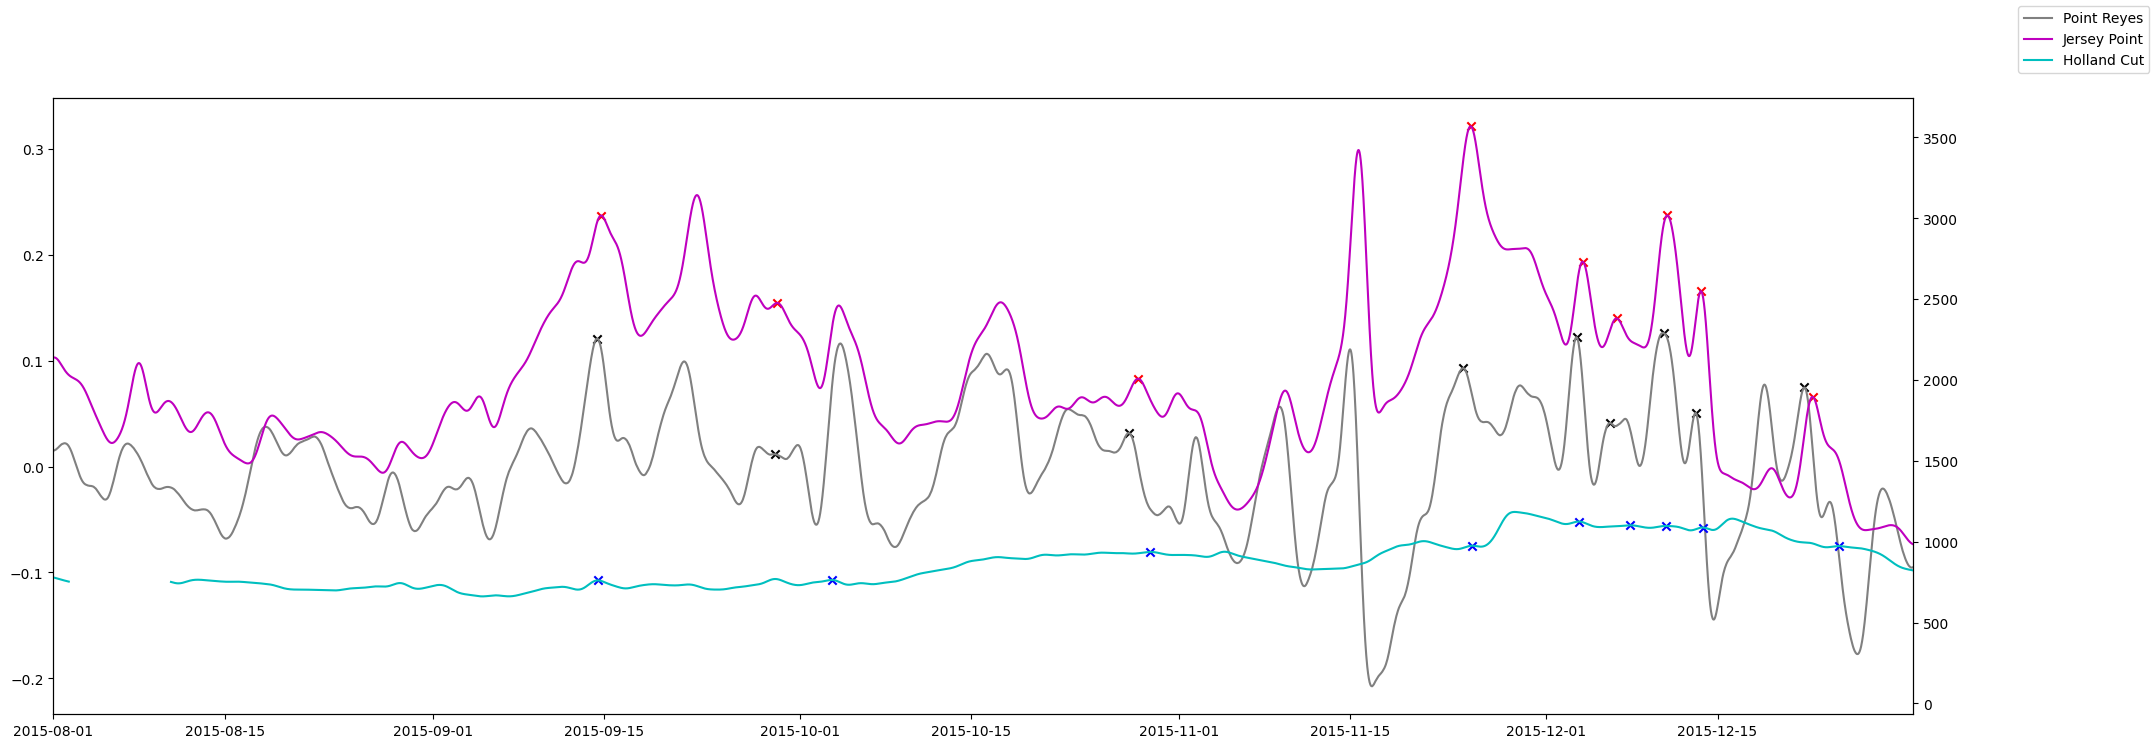

In [74]:
#Zoom into 2015
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2015,8,1),datetime(2015,12,31)])
ax1.set_xlim([datetime(2015,8,1),datetime(2015,12,31)])

# Make the frequency duration plot for the 59 events that make it to Holland Cut

59
59


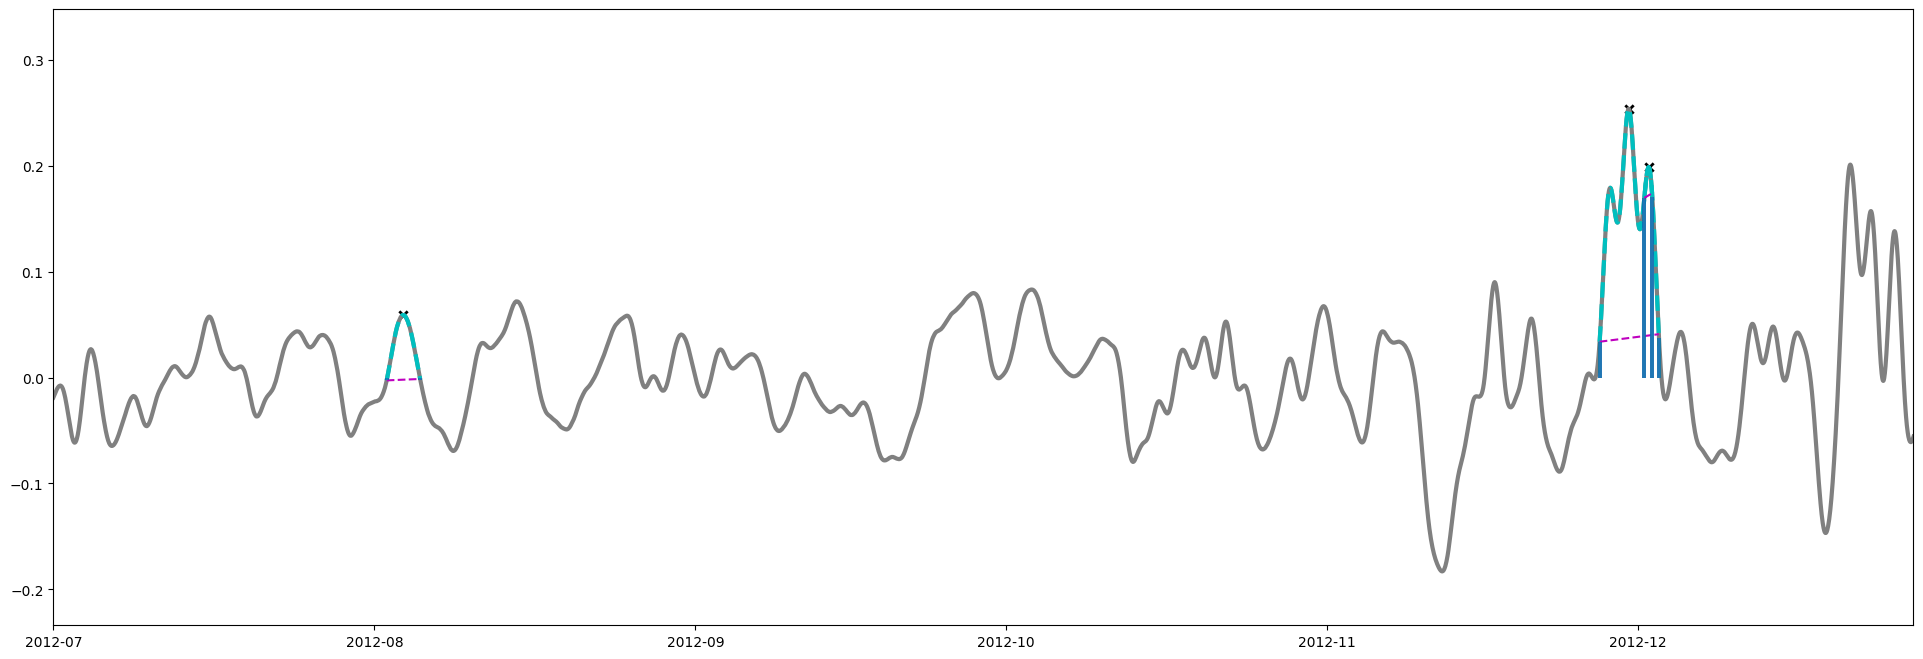

59
59


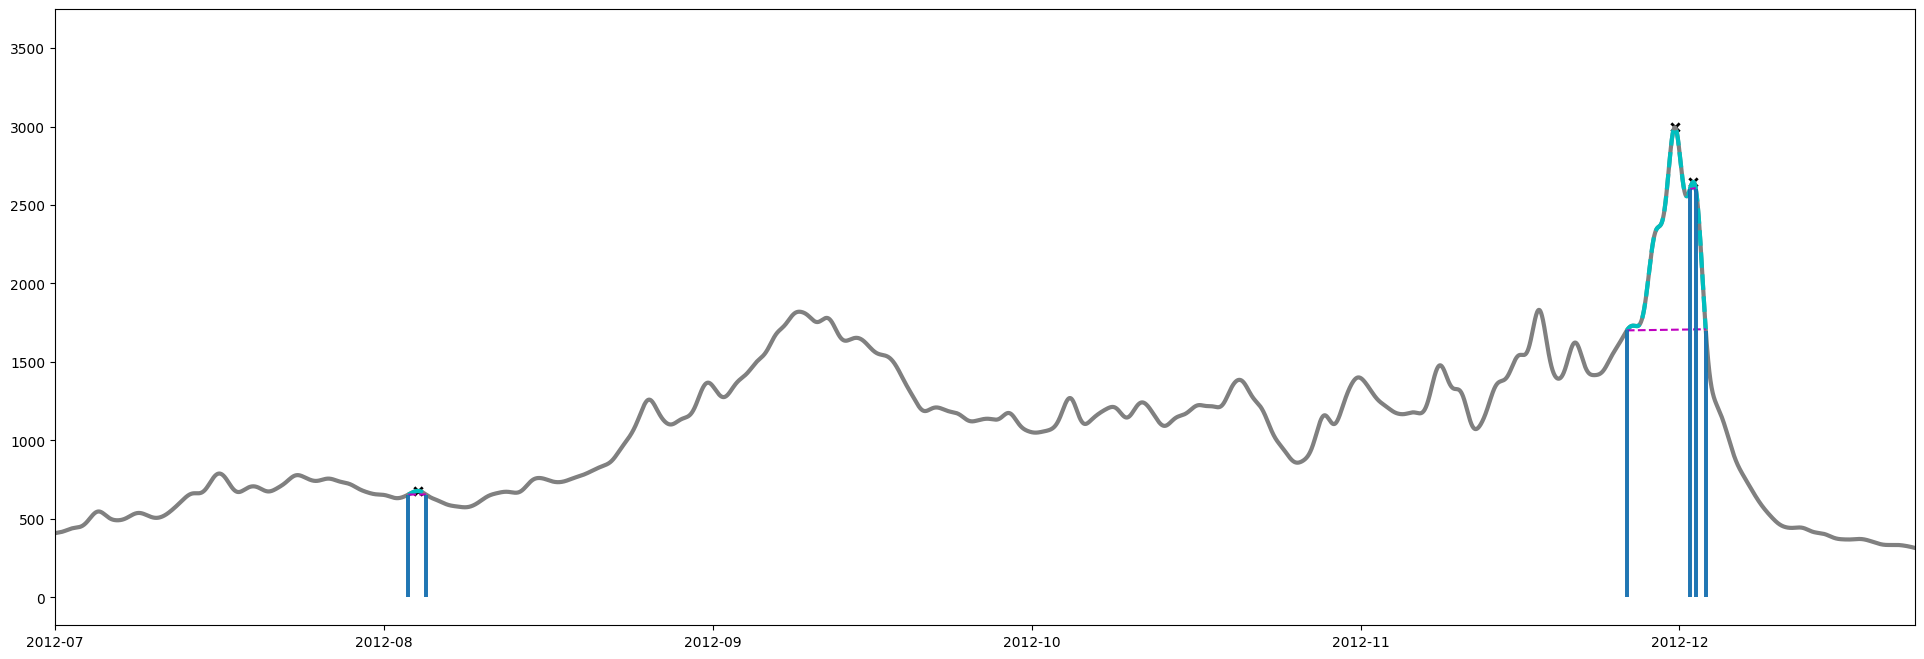

59
53


In [75]:
x_pr=df_f_wo21.pr.dropna().index
y_pr=df_f_wo21.pr.dropna().values
#unit_area(x,y,properties,peaks,dt,labelstr,peaksubset)
inten_u_pr, dur_pr, mfc_pr = unit_area(x_pr,y_pr,propertiespr,pr_indices[peakspr],0.5,'pt reyes',peak_pr24h,1)
x_jp=df_f_wo21.jp.dropna().index
y_jp=df_f_wo21.jp.dropna().values
inten_u_jp, dur_jp, mfc_jp = unit_area(x_jp,y_jp,propertiesjp,jp_indices[peaksjp],0.25,'Jersey Point',peak_jp24h,1)
x_hol2=df_f_wo21.hol2.dropna().index
y_hol2=df_f_wo21.hol2.dropna().values
inten_u_hol2, dur_hol2, mfc_hol2 = unit_area(x_hol2,y_hol2,propertieshol2,hol2_indices[peakshol2],0.25,'Holland Cut',peak_hol224h,0)

# x_hol2=df_f_wo21.hol2.dropna().index
# y_hol2=df_f_wo21.hol2.dropna().values
# inten_u_hol2, dur_hol2, mfc_hol2 = unit_area(x_hol2,y_hol2,propertieshol2,peakshol2,0.5,'Holland Cut',peak_hol224h)

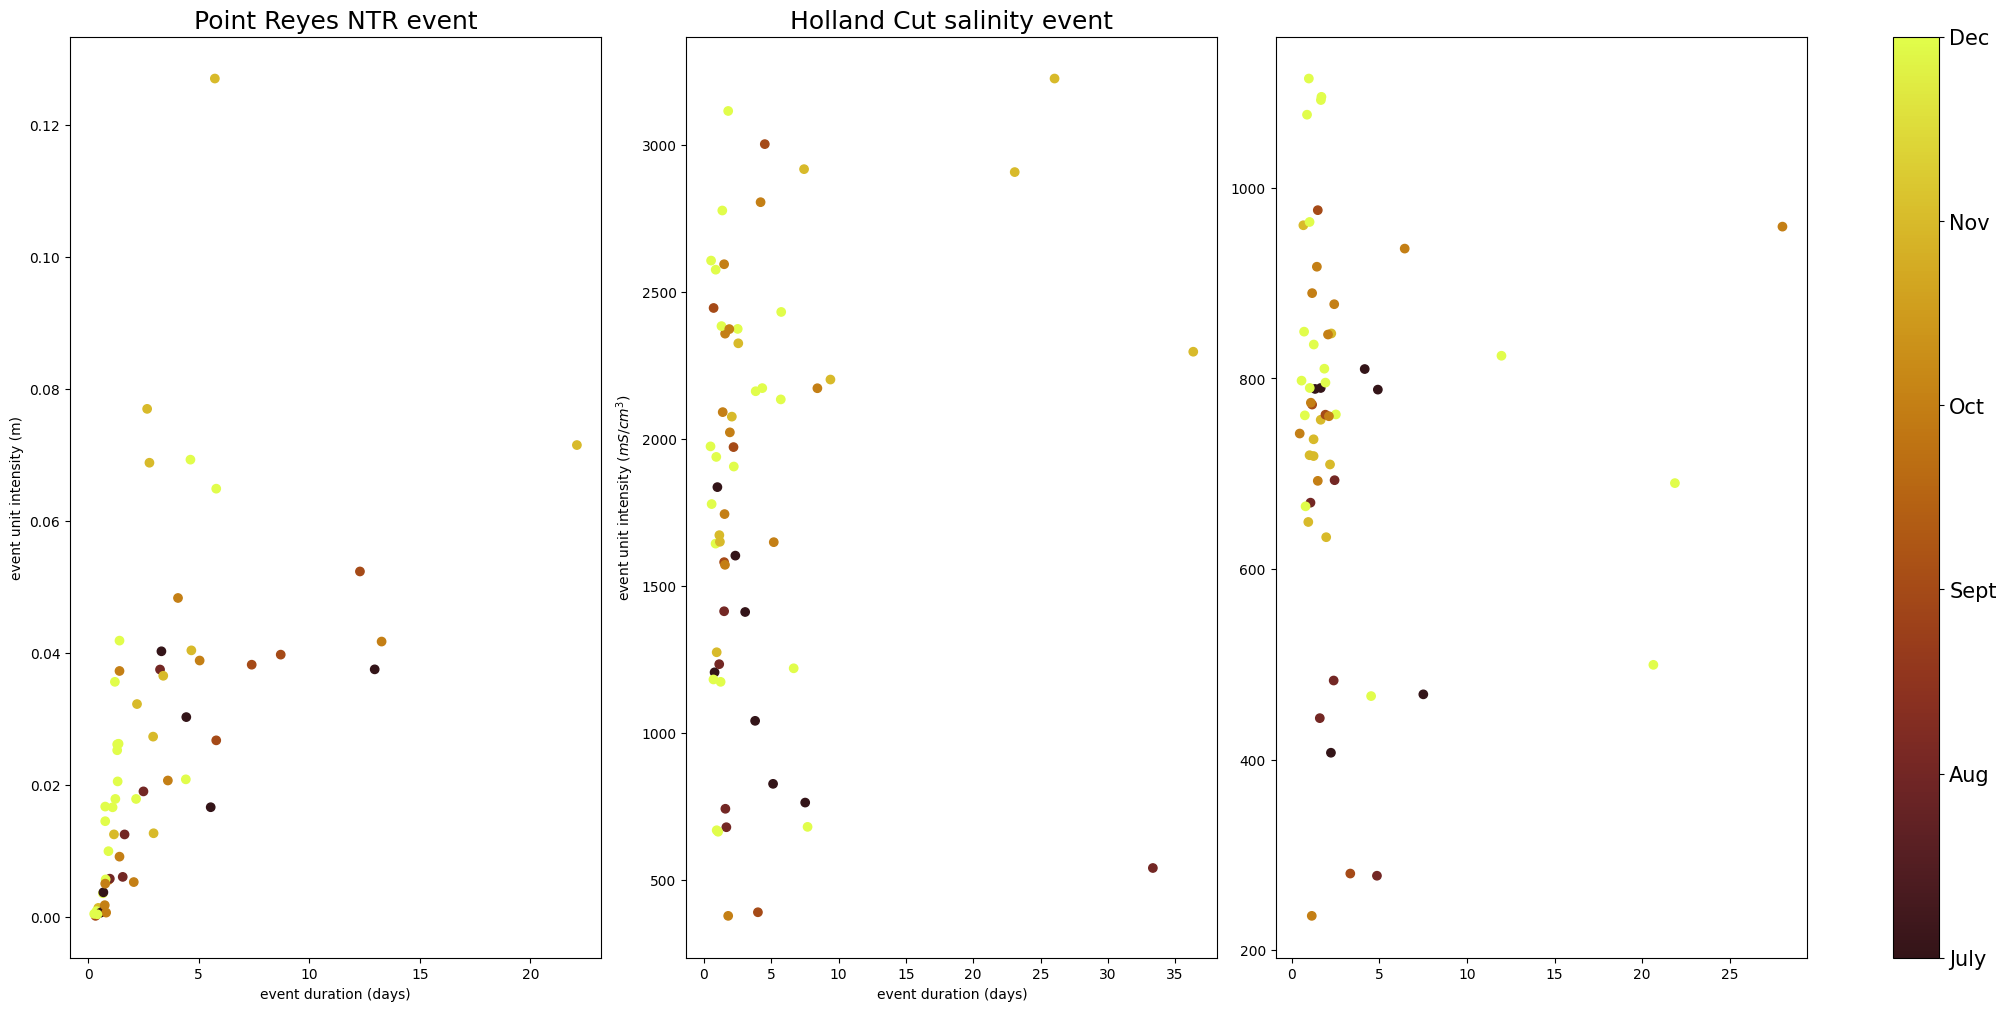

In [76]:
# Plot intensity- duration for each location
#add colorbar
fig, ax = plt.subplots(1,3,layout='constrained',figsize= (20,10))
# setting font sizeto 30
plt.rcParams.update({'font.size': 15})
pts0=ax[0].scatter(dur_pr/24,inten_u_pr,c=mfc_pr,cmap=cmocean.cm.solar)
ax[0].set_xlabel('event duration (days)')
ax[0].set_ylabel('event unit intensity (m)')
#ax[1].set_xlim(0,12)
ax[0].set_title('Point Reyes NTR event')
# cbar=fig.colorbar(pts0, ax=ax)
# cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])

pts1=ax[1].scatter(dur_jp/24,inten_u_jp,c=mfc_jp,cmap=cmocean.cm.solar)
ax[1].set_xlabel('event duration (days)')
ax[1].set_ylabel('event unit intensity ($mS/cm^3$)')
#ax[1].set_xlim(0,12)
ax[1].set_title('Jersey Point salinity event')

pts2=ax[2].scatter(dur_hol2/24,inten_u_hol2,c=mfc_hol2,cmap=cmocean.cm.solar)
ax[1].set_xlabel('event duration (days)')
ax[1].set_ylabel('event unit intensity ($mS/cm^3$)')
#ax[1].set_xlim(0,12)
ax[1].set_title('Holland Cut salinity event')


cbar=fig.colorbar(pts2, ax=ax)
cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])
plt.show()

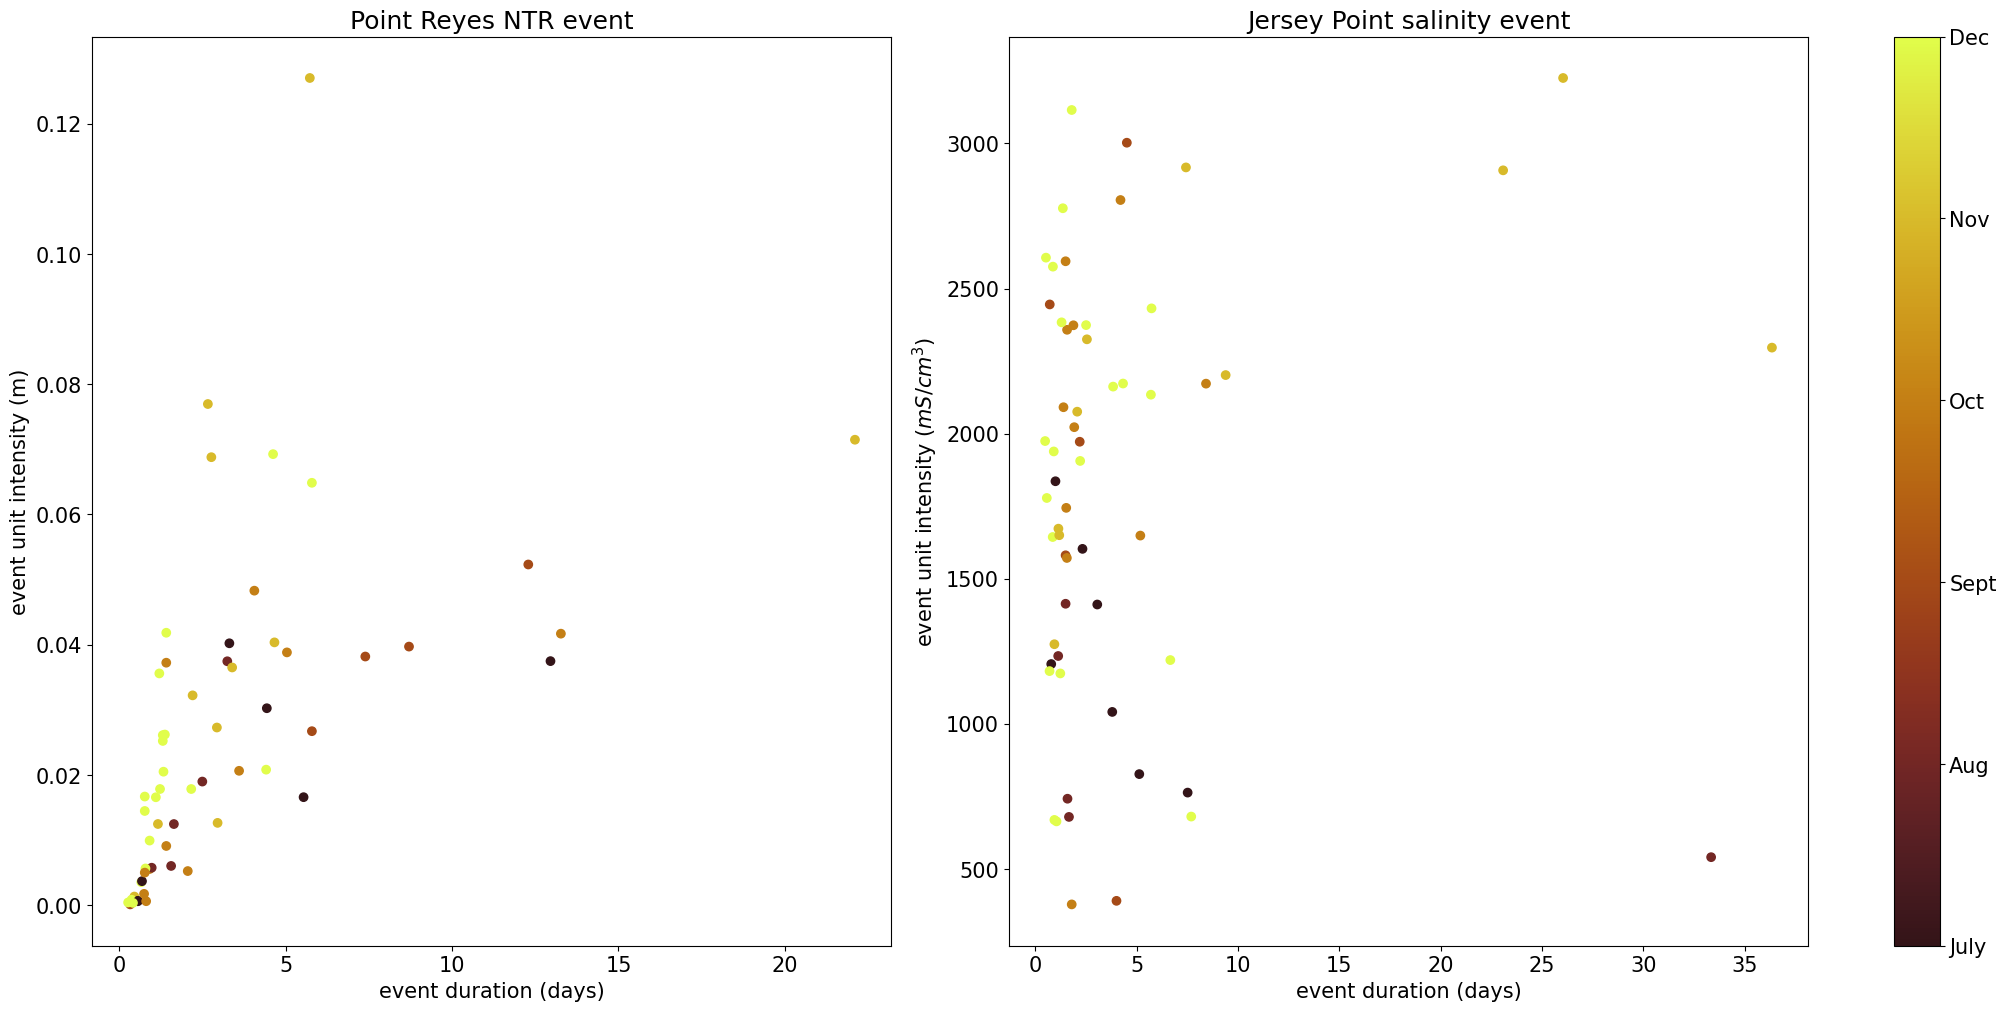

In [77]:
# Plot intensity- duration for each location
inten_u_jp, dur_jp
#add colorbar
fig, ax = plt.subplots(1,2,layout='constrained',figsize= (20,10))
# setting font sizeto 30
plt.rcParams.update({'font.size': 15})
pts0=ax[0].scatter(dur_pr/24,inten_u_pr,c=mfc_pr,cmap=cmocean.cm.solar)
ax[0].set_xlabel('event duration (days)')
ax[0].set_ylabel('event unit intensity (m)')
#ax[1].set_xlim(0,12)
ax[0].set_title('Point Reyes NTR event')
# cbar=fig.colorbar(pts0, ax=ax)
# cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])

pts1=ax[1].scatter(dur_jp/24,inten_u_jp,c=mfc_jp,cmap=cmocean.cm.solar)
ax[1].set_xlabel('event duration (days)')
ax[1].set_ylabel('event unit intensity ($mS/cm^3$)')
#ax[1].set_xlim(0,12)
ax[1].set_title('Jersey Point salinity event')
cbar=fig.colorbar(pts1, ax=ax)
cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])
plt.show()

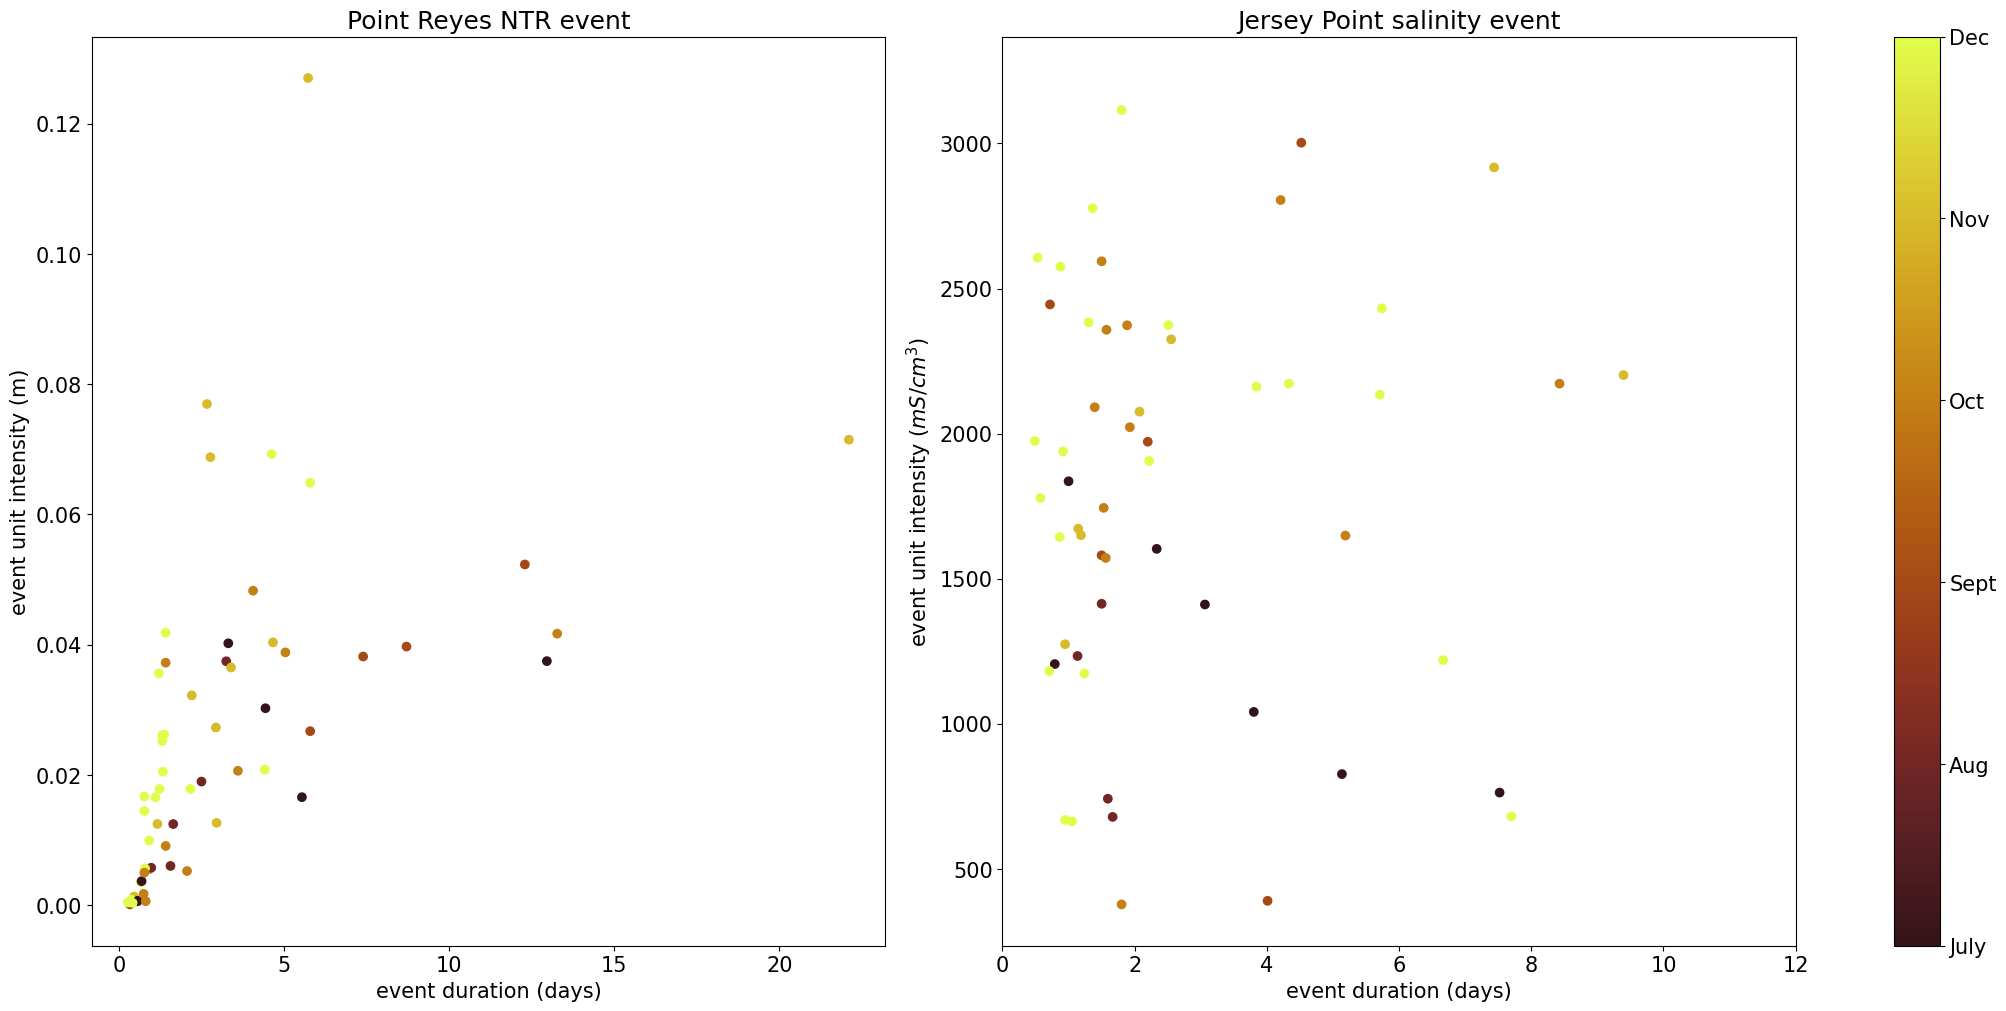

In [78]:
# Plot intensity- duration for each location
inten_u_jp, dur_jp
#add colorbar
fig, ax = plt.subplots(1,2,layout='constrained',figsize= (20,10))
# setting font sizeto 30
plt.rcParams.update({'font.size': 15})
pts0=ax[0].scatter(dur_pr/24,inten_u_pr,c=mfc_pr,cmap=cmocean.cm.solar)
ax[0].set_xlabel('event duration (days)')
ax[0].set_ylabel('event unit intensity (m)')
ax[1].set_xlim(0,12)
ax[0].set_title('Point Reyes NTR event')
# cbar=fig.colorbar(pts0, ax=ax)
# cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])

pts1=ax[1].scatter(dur_jp/24,inten_u_jp,c=mfc_jp,cmap=cmocean.cm.solar)
ax[1].set_xlabel('event duration (days)')
ax[1].set_ylabel('event unit intensity ($mS/cm^3$)')
ax[1].set_xlim(0,12)
ax[1].set_title('Jersey Point salinity event')
cbar=fig.colorbar(pts1, ax=ax)
cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])
plt.show()

# Make histograms of peak height and width

In [81]:
def extract_prop(properties,peaks,peaksubset,unit,dt,plotflag):
    #where properties is the object output from find_peaks associated with
    #peaks, but the peaks passed here should have the same units as peaksubset
    #typically datetime or unitless index
    #unit is the unit of the y data passed to find_peaks, either mS/cm^3 or 
    # m
    #dt is the amount of time between samples passed to find_peaks in hours
    #e.g. for the salinity data it should be 0.25 but for the SCHA pt reyes data 0.5
    if len(peaks)>len(peaksubset):
        peakidx=np.in1d(peaks,peaksubset)
    else:
        peakidx=np.arange(0,len(peaks))
    prominences=properties["prominences"][peakidx]
    widths=properties["widths"][peakidx]
    if plotflag==1:
        fig, ax = plt.subplots(1,2,layout='constrained')
        ax[0].hist(prominences)
        ax[1].hist(widths*dt)
        ax[0].set_xlabel('Peak prominence ['+unit+']')
        ax[1].set_xlabel('Peak width [h]')
    return prominences, widths

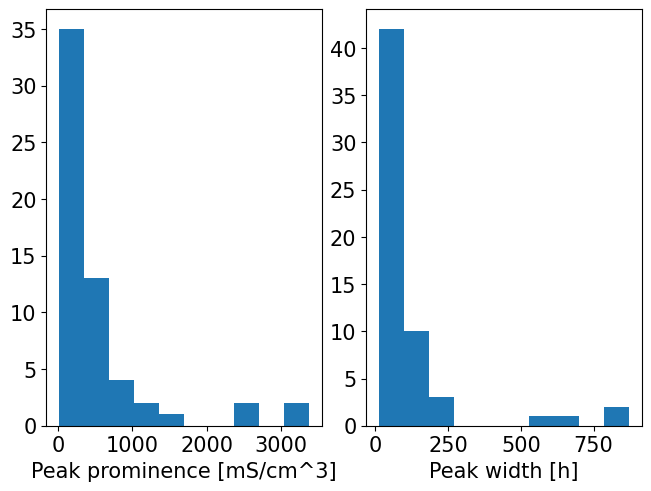

In [85]:
#prominencespr, widthspr = extract_prop(propertiespr,pr_indices[peakspr],peak_pr24h,'m',0.5,1)
prominencesjp, widthsjp = extract_prop(propertiesjp,jp_indices[peaksjp],peak_jp24h,'mS/cm^3',0.25,1)
#prominenceshol2, widthshol2 = extract_prop(propertieshol2,hol2_indices[peakshol2],peak_hol224h,'mS/cm^3',0.25,1)

# inten_u_pr, dur_pr, mfc_pr = unit_area(x_pr,y_pr,propertiespr,pr_indices[peakspr],0.5,'pt reyes',peak_pr24h,1)

# inten_u_jp, dur_jp, mfc_jp = unit_area(x_jp,y_jp,propertiesjp,jp_indices[peaksjp],0.25,'Jersey Point',peak_jp24h,1)
# x_hol2=df_f_wo21.hol2.dropna().index
# y_hol2=df_f_wo21.hol2.dropna().values
# inten_u_hol2, dur_hol2, mfc_hol2 = unit_area(x_hol2,y_hol2,propertieshol2,hol2_indices[peakshol2],0.25,'Holland Cut',peak_hol224h,0)


# What are the lags between events at different locations?

In [96]:
#subtract the dates in each peak_*24h
jp_lags=(peak_jp24h-peak_pr24h).astype(np.float)/(10**9*60*60) #convert from ns to h
hol2_lags=(peak_hol224h-peak_pr24h).astype(np.float)/(10**9*60*60) #convert from ns to h

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel pac

In [95]:
((peak_jp24h-peak_pr24h).astype(np.float)/(10**9*60*60))

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


array([ 9.25, 11.25,  6.5 , 13.75, 11.  , 17.5 , 17.  ,  3.5 , 18.25,
       13.  , 14.25,  8.25, 16.  ,  5.5 ,  8.75, 13.5 ,  4.  , 15.5 ,
       14.25, 11.5 ,  8.5 ,  3.75, 18.5 , 14.  , 11.75, 13.5 ,  7.5 ,
       10.5 , 15.75,  8.75,  3.  , 20.  , 22.  , 22.5 ,  7.25, 11.5 ,
       23.25, 16.5 , 22.75,  3.5 ,  8.25, 14.5 ,  6.75,  6.5 , 13.75,
       19.75, 14.25,  6.  , 12.  , 14.5 ,  5.5 ,  7.25, 16.25, 11.  ,
        7.  , 15.75, 21.25, 13.75,  9.25])

Text(0.5, 0, 'Lag [h] P Reyes and Holl Cut')

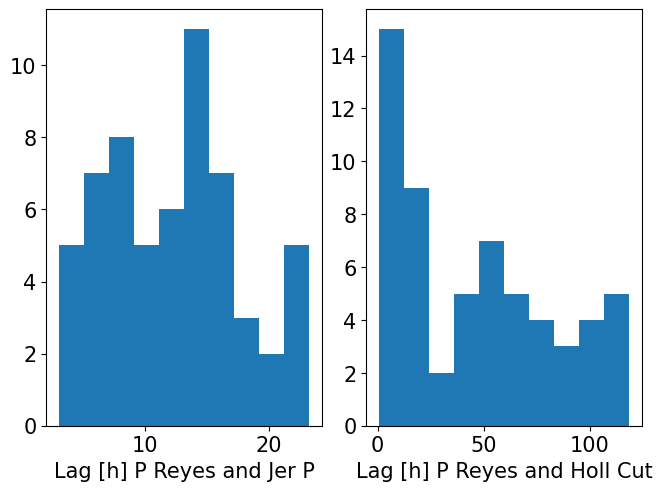

In [99]:
fig, ax =plt.subplots(1,2,layout='constrained')

ax[0].hist(jp_lags)
ax[1].hist(hol2_lags)
ax[0].set_xlabel('Lag [h] P Reyes and Jer P')
ax[1].set_xlabel('Lag [h] P Reyes and Holl Cut')

In [ ]:
np.in1d(df_f_wo21.index[peaksjp],peak_jp24h)

In [88]:
print(peak_pr24h[0])
print(peak_jp24h[0])

2012-08-03T19:00:00.000000000
2012-08-04T04:15:00.000000000


In [ ]:
peak_pr24h

In [ ]:
df_f_wo21.index[peaksjp]

In [ ]:
df_f_wo21.datetime.loc[peak_jp24h]

In [ ]:
peak_jp24h

In [ ]:
print(len(peak_jp24h))
print(len(peaksjp))

In [ ]:
pr_indices.values[0]

In [ ]:
#add colorbar
fig, ax = plt.subplots()

pts=ax.scatter(dur_pr/24,inten_u_pr,c=mfc,cmap=cmocean.cm.solar)
ax.set_xlabel('event duration (days)')
ax.set_ylabel('event unit intensity (m)')
ax.set_xlim(0,12)
ax.set_title('Point Reyes NTR event')
cbar=fig.colorbar(pts, ax=ax)
cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])
plt.show()

# Using all the Jersey Point events

In [ ]:
#what if we just look at where Jersey Point has a peak and use those events
peak_pr24h=np.array([])
peak_jp24h=np.array([])
#peak_hol224h=np.array([])
win=24 #number of hours to include in searc

count_j=0
count_h=0
for p in peakspr:
    #need to map this index back to the data frame
    x=pr_indices[p]
    x2=x+pd.Timedelta(hours=win)
    if df_f_wo21.jp_peak[x:x2].sum()>0:
        count_j=count_j+1  
        peak_pr24h=np.append(peak_pr24h,x)
        peak_jp24h=np.append(peak_jp24h,x+pd.Timedelta(minutes=df_f_wo21.jp_peak[x:x2].argmax()*15))
idx=np.arange(0,len(df_f_wo21.pr.values))
print(len(peak_pr24h))
print(count_j)
df_f_wo21['all_peak_24h']=np.isin(idx,peak_pr24h)

In [ ]:
# try plotting these 19 events, split the period of time into 4 sections
fig, ax =plt.subplots(4,1,sharey=True,figsize=(24,8))

ax[0].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[0].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax1=ax[0].twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax[0].set_xlim([datetime(2012,8,1),datetime(2014,12,31)])
ax1.set_xlim([datetime(2012,8,1),datetime(2014,12,31)])

ax[1].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[1].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax2=ax[1].twinx()
ax2.plot(df_f_wo21.jp,color='m')
ax2.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax[1].set_xlim([datetime(2015,8,1),datetime(2017,12,31)])
ax2.set_xlim([datetime(2015,8,1),datetime(2017,12,31)])

ax[2].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[2].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax3=ax[2].twinx()
ax3.plot(df_f_wo21.jp,color='m')
ax3.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax[2].set_xlim([datetime(2018,8,1),datetime(2020,12,31)])
ax3.set_xlim([datetime(2018,8,1),datetime(2020,12,31)])

ax[3].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[3].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax4=ax[3].twinx()
ax4.plot(df_f_wo21.jp,color='m')
ax4.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax[3].set_xlim([datetime(2021,8,1),datetime(2023,12,31)])
ax4.set_xlim([datetime(2021,8,1),datetime(2023,12,31)])

plt.show()

In [ ]:
#calculate the duration of the jersey point peak and the area under the curve


In [ ]:
#compare with intensity and duration of the point reyes events

In [ ]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(df_f_wo21.pr,color='grey')
ax.scatter(df_f_wo21.datetime.iloc[peak_pr24h], df_f_wo21.pr.iloc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax.vlines(df_f_wo21.datetime.iloc[peak_pr24h], -0.2, 0.2, color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.iloc[peak_jp24h],df_f_wo21.jp.iloc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.iloc[peak_hol224h],df_f_wo21.hol2.iloc[peak_hol224h],label="Holland Cut",marker="x",color='b')

# #what if we also plot all of the prominent hol2 peaks
# ax1.scatter(df_f_wo21.datetime.iloc[peakshol224h],df_f_wo21.hol2.iloc[peakshol210],marker="*",color='k')

ax.set_xlim([datetime(2014,8,1),datetime(2014,12,1)])
ax1.set_xlim([datetime(2014,8,1),datetime(2014,12,1)])

In [ ]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(df_f_wo21.pr,color='grey')
ax.scatter(df_f_wo21.datetime.iloc[peak_pr24h], df_f_wo21.pr.iloc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax.vlines(df_f_wo21.datetime.iloc[peak_pr24h], -0.2, 0.2, color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.iloc[peak_jp24h],df_f_wo21.jp.iloc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.iloc[peak_hol224h],df_f_wo21.hol2.iloc[peak_hol224h],label="Holland Cut",marker="x",color='b')

# #what if we also plot all of the prominent hol2 peaks
# ax1.scatter(df_f_wo21.datetime.iloc[peakshol210],df_f_wo21.hol2.iloc[peakshol210],marker="*",color='k')

ax.set_xlim([datetime(2022,8,1),datetime(2022,12,1)])
ax1.set_xlim([datetime(2022,8,1),datetime(2022,12,1)])

In [ ]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(df_f_wo21.pr,color='grey')
ax.scatter(df_f_wo21.datetime.iloc[peak_pr24h], df_f_wo21.pr.iloc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax.vlines(df_f_wo21.datetime.iloc[peak_pr24h], -0.2, 0.2, color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.iloc[peak_jp24h],df_f_wo21.jp.iloc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.iloc[peak_hol224h],df_f_wo21.hol2.iloc[peak_hol224h],label="Holland Cut",marker="x",color='b')

# #what if we also plot all of the prominent hol2 peaks
# ax1.scatter(df_f_wo21.datetime.iloc[peakshol210],df_f_wo21.hol2.iloc[peakshol210],marker="*",color='k')

ax.set_xlim([datetime(2014,8,1),datetime(2023,12,1)])
ax1.set_xlim([datetime(2014,8,1),datetime(2023,12,1)])